This notebook performs preliminary tests on using SPTk for CaSSIS.

# SPTK Configuration


We will use sptk in the same configuration as for the PanCam work - i.e. over the range of 400 - 1100 nm.

# Data

Here we use the same spectral library as the previous study, but now use the CaSSIS instrument transmission.

## Spectral Library

We will use the same spectral library as for the PanCam study previously.

The study uses a set of materials expected at the anticipated ExoMars rover landing site of Oxia Planum. We represent:

- the *Fe/Mg-rich clay unit* with **vermiculite** and **saponite** ([Carter et al., 2016](https://www.hou.usra.edu/meetings/lpsc2016/pdf/2064.pdf])),
- the *mafic-rich capping unit* with **basalt** and **basaltic soil** ([Quantin-Nataf et al., 2021](https://doi.org/10.1089/ast.2019.2191)). 
- a putative *Al-rich clay unit* with **montmorillonite** ([Turner et al., 2021](https://ui.adsabs.harvard.edu/abs/2021LPI....52.2490T/abstract)), 
- and **hematite**, that has been reported in orbital Gamma-Ray Spectroscopy observations ([Da Pieve et al.,2021](https://doi.org/10.1029/2020JE006488)), but has not yet been reported from orbital reflectance spectroscopy studies of Oxia Planum. 

We consider the detection of hematite, as a target, against a background of the mafic and clay mineralogy expected at Oxia Planum.

For each mineral species, we selected multiple entries of reflectance spectra via the Western Washington University Visible and Infrared Spectroscopy brOwseR ([VISOR](https://westernreflectancelab.com/visor/)).

### Downloading the study Spectral Library

The spectral library is archived, as downloaded from ViSOR at the time of the study, and can be downloaded from the following Zenodo repository: doi:[10.5281/zenodo.10684347](https://zenodo.org/doi/10.5281/zenodo.10684347). After downloading and unzipping the spectral library, be sure to place the ```stabbins2024_exmpc_hematite_spectral_library/``` directory in the ```sptk/data/spectral_library``` directory of your local **sptk** repository (that should also be the host for this Notebook).

For details of how to access the VISOR data and prepare a new spectral library directory yourself, please see the example notebook: [material_collection_example.ipynb](/examples/material_collection_example.ipynb).

### Loading the Spectral Library into sptk

We use the MaterialCollection class of **sptk** to load and host the dataset.

In [97]:
from sptk.material_collection import MaterialCollection

The primary argument of the ```MaterialCollection``` constructor is the ```materials```, that defines the classes that we wish to separate (target='hematite', background='basalt+clay'), and assigns to these the mineral group names, as defined in the spectral library directory.

In [2]:
MATERIAL_SET = {
    'tg: hematite': [('hematite', '*')],
    'bg: basalt+clays': [
                ('basalt', '*'),
                ('vermiculite', '*'),
                ('saponite', '*'),
                ('montmorillonite', '*')]}

Note we use the wildcard ```*``` to tell the constructor to select all available files in each mineral group directory.

We set a ```PROJECT_NAME``` that will be used throughout the study:

In [3]:
PROJECT_NAME = 'cassis_sptk_development'

We initialise a new MaterialCollection object with this material dictionary, as follows:

In [4]:
matcol = MaterialCollection(
            materials=MATERIAL_SET, # defines the material classes and their mineral group constituents
            spectral_library='stabbins2024_exmpc_hematite_spectral_library', # the spectral library directory to use
            project_name=PROJECT_NAME, # the name of the project
            load_existing=False, # if True, load an existing Material Collection from the project directory
            balance_classes=False, # if True, ensure equal number of entries in each class
            random_bias_seed=None, # if set to an integer this ensures repeatable class balancing
            allow_out_of_bounds=False, # if False, discard entries of the spectral library that don't span the spectral range
            plot_profiles=False, # if true, plot profiles durign construction
            export_df=False) # if true, save the output for later access during construction

Building new cassis_sptk_development MaterialCollection DF



hematite: HEM 103_888.csv loaded
hematite: HEM 103_f1_15930.csv loaded
hematite: HEM101_7928.csv loaded
hematite: HEM101_f1_11183.csv loaded
hematite: HEM101_f2_15181.csv is out of bounds, removing...
hematite: HEM102_12158.csv is out of bounds, removing...
hematite: HEM102_f1_12805.csv loaded
hematite: HEM103_0_896.csv loaded
hematite: HEM103_10_906.csv loaded
hematite: HEM103_11381.csv loaded
hematite: HEM103_11_907.csv loaded
hematite: HEM103_12_908.csv loaded
hematite: HEM103_1_897.csv loaded
hematite: HEM103_2_898.csv loaded
hematite: HEM103_3_899.csv loaded
hematite: HEM103_4_900.csv loaded
hematite: HEM103_5_901.csv loaded
hematite: HEM103_6_902.csv loaded
hematite: HEM103_7_903.csv loaded
hematite: HEM103_8_904.csv loaded
hematite: HEM103_9_905.csv loaded
hematite: HEM103_f10_13060.csv loaded
hematite: HEM103_f11_13340.csv loaded
hematite: HEM103_f12_13357.csv loaded
hematite: HEM103_f13_13523.csv loaded
hematite: HEM103_f14_13950.csv loaded
hematite: HEM103_f15_14159.csv loade

This creates a folder in the ```spectral_parameter_studies``` directory, under the project name, to log the results of the processing throughout the study.

We can check the distribution of the entries in the classes and mineral types, prior to applying class balancing:

In [5]:
matcol.print_category_entries(print_minerals=True)

Samples in tg: hematite class: 60
Unique sample sources in tg: hematite class: 60
  Samples in hematite mineral group: 60
Samples in bg: basalt+clays class: 265
Unique sample sources in bg: basalt+clays class: 265
  Samples in basalt mineral group: 68
  Samples in montmorillonite mineral group: 102
  Samples in saponite mineral group: 76
  Samples in vermiculite mineral group: 19


We see there are 205 more basalt and clay samples than hematite samples.

We then apply class balancing. This performs a simple undersampling method that discards entries from the largest categories, and mineral groups, until all are of equal size. We also discard any entry whose spectral range does not span the complete range of the sampling instrument.

By balancing the classes, we asume no prior knowledge of the abundances of the materials in the environment under investigation. Although this can in principle be estimated at the scale of orbital observations, at the more local rover-level observations that PanCam will perform, this distribution is hard to estimate a priori. 

Here we fix the random seed number to 0, for reproducibility:

In [6]:
matcol.balance_mineral_groups(random_state=0)

Balancing class sizes...


and we check the new distribution of entries:

In [7]:
matcol.print_category_entries(print_minerals=True)

Samples in tg: hematite class: 60
Unique sample sources in tg: hematite class: 60
  Samples in hematite mineral group: 60
Samples in bg: basalt+clays class: 60
Unique sample sources in bg: basalt+clays class: 60
  Samples in basalt mineral group: 15
  Samples in montmorillonite mineral group: 15
  Samples in saponite mineral group: 15
  Samples in vermiculite mineral group: 15


Note that the process reports that the final dataset has 60 entries in each category.

We save this reduced material collection:

In [8]:
matcol.export_main_df()

Exporting the Material Collection to CSV and Pickle formats...


## Instrument

This work has been conducted in preparation for the operation of PanCam, the panoramic stereo multispectral imaging system ([Coates et al., 2017](https://doi.org/10.1089/ast.2016.1548)) of the ESA ExoMars Rosalind Franklin rover ([Vago et al., 2017](https://doi.org/10.1089/ast.2016.1533)). Rosalind Franklin has the primary objective of finding evidence of ancient life in the subsurface of Mars at Oxia Planum, an ancient clay-rich terrain ([Quantin-Nataf et al., 2021](https://doi.org/10.1089/ast.2019.2191)). 

PanCam will provide visual characterisation of the geology of the landing site, and, with tricolour and 12-channel multispectral visible-to-near-infrared (VNIR) imaging, a preliminary assessment of the material composition. 

We have represented the spectral sampling of the PanCam Geology filter set with Gaussian transmission profiles:

$T(\lambda |\lambda_{CWL}, \Delta\lambda) = \exp\left(\frac{-(\lambda-\lambda_{CWL}\ )^2}{2(\Delta\lambda/2\sqrt{2\ln{2}})^2}\right)$

using the centre wavelength ($\lambda_{CWL}$) and full-width-at-half-maximum ($\Delta\lambda$) of each filter given by [Coates et al., 2017](https://doi.org/10.1089/ast.2016.1548).


### Downloading the Instrument Data File

The ```exm_pc_geol.csv``` file that hosts the instrument information required to execute this notebook is also hosted in the accompanying Zenodo repository that the spectral library is hosted in. Recall that this can be found at: doi:[10.5281/zenodo.10684347](https://zenodo.org/doi/10.5281/zenodo.10684347). 

After downloading the repository, be sure to place the ```exm_pc_geol.csv``` file in the ```sptk/data/instruments``` directory of your local **sptk** repository (that should also be the host for this Notebook).


### Loading representative filters of ExoMars PanCam

The filter information is loaded and represented with an Instrument object:

In [9]:
from sptk.instrument import Instrument

We initialise and build the instrument object using data for the $\lambda_{CWL}$ and $\Delta\lambda$ hosted in the **sptk** distribution. We access this via the name string 'exm_pc_geol' (ExoMars PanCam Geology Filters), that is the name of the csv file that stores this data. The project name is inherited from the MaterialCollection instance.

In [10]:
inst = Instrument(
            name = 'exm_cassis_cwls', # filename of the instrument information, held in /software/data/instruments/
            project_name = matcol.project_name, # the project directory name, hosting outputs in the /spectral_parameter_studies/ directory
            load_existing=False, # if True, load existing instrument data from the project directory
            plot_profiles=False, # if true, plot the transmission profiles during construction
            export_df=True) # if True, export the instrument transmission profiles to the project directory

Building Instrument...
Building new DataFrame for 'exm_cassis_cwls'...
Exporting the Instrument to CSV and Pickle formats...


## Sampling the Dataset with the Instrument

We sample the material collection with the instrument via the Observation
class:

In [11]:
from sptk.observation import Observation

The sampling is performed during initialisation, by passing the Observation the MaterialCollection and Instrument instances initialised in the previous steps.

In [12]:
obs = Observation(
        material_collection=matcol, # the MaterialCollection object to sample
        instrument=inst, # the instrument to use to perform the sampling
        load_existing=False, # if True, load existing re-sampled data from the project directory
        plot_profiles=False, # if True, plot the instrument-sampled data
        export_df=True) # if True, export the data to the project directory

Building new Observation DataFrame                                                  for 'cassis_sptk_development'...
Sampling the Material Collection with the Instrument...
Sampling complete.
Exporting the Observation Pickle format...
Observation export complete.


## Figure 1. A.



We can visualise the material collection, and it's distribution across the target and background categories by plotting the data:

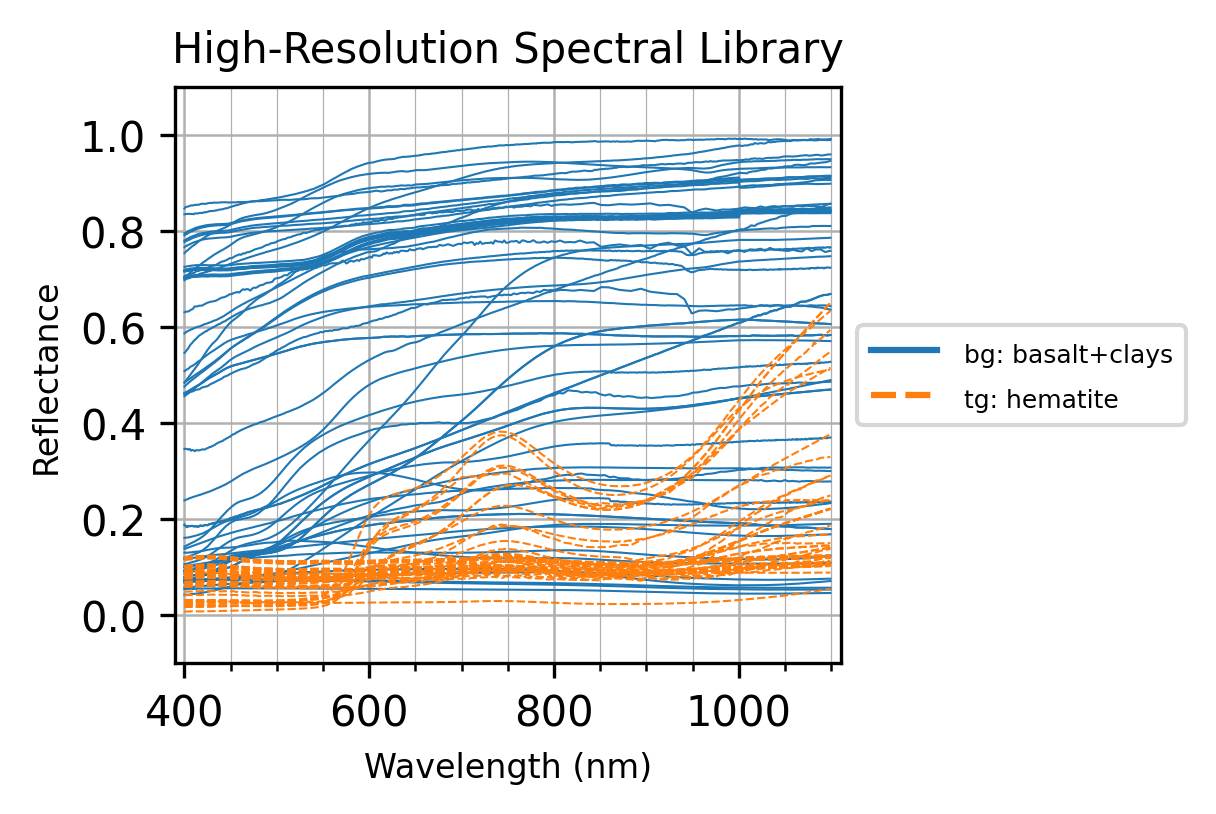

In [13]:
matcol.plot_profiles(categories_only=True)

Original File link: [../projects/stabbins2024_exmpc_hematite_paper_data_products/material_collection/plots/stabbins2024_exmpc_hematite_paper_walkthrough_all_entries_all.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/material_collection/plots/stabbins2024_exmpc_hematite_paper_walkthrough_all_entries_all.png)

## Dataset 1

Original Material Collection file: [../projects/stabbins2024_exmpc_hematite_paper_data_products/material_collection/tables/material_collection.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/material_collection/tables/material_collection.csv)

In [14]:
matcol.main_df.head()

Filepath  \
Data ID                                                               
HEM 103_888       spectral_library/stabbins2024_exmpc_hematite_s...   
HEM 103_f1_15930  spectral_library/stabbins2024_exmpc_hematite_s...   
HEM101_7928       spectral_library/stabbins2024_exmpc_hematite_s...   
HEM101_f1_11183   spectral_library/stabbins2024_exmpc_hematite_s...   
HEM102_f1_12805   spectral_library/stabbins2024_exmpc_hematite_s...   

                      Category   Sample ID Mineral Name  \
Data ID                                                   
HEM 103_888       tg: hematite     HEM 103     hematite   
HEM 103_f1_15930  tg: hematite  HEM 103_f1     hematite   
HEM101_7928       tg: hematite      HEM101     hematite   
HEM101_f1_11183   tg: hematite   HEM101_f1     hematite   
HEM102_f1_12805   tg: hematite   HEM102_f1     hematite   

                                                 Sample Description  \
Data ID                                                               
HEM 103_888                                         Many purple XLs   
HEM 103_f1_15930               9.6. Other oxides: ASD spectra (PSF)   
HEM101_7928                          Pigment mixed with linseed oil   
HEM101_f1_11183   9.6. Other oxides: RELAB + Nicolet / Merged RE...   
HEM102_f1_12805   9.6. Other oxides: RELAB + Nicolet / Merged RE...   

                                  Date Added Viewing Geometry  \
Data ID                                                         
HEM 103_888       2022-04-27 19:59:56.925217          I30_ e0   
HEM 103_f1_15930  2022-04-27 19:59:56.954227           30 / 0   
HEM101_7928       2022-04-27 19:59:56.981127          I30_ e0   
HEM101_f1_11183   2022-04-27 19:59:57.009525           30 / 0   
HEM102_f1_12805   2022-04-27 19:59:57.090445           30 / 0   

                 Other Information Formula Composition  ...    1090.0  \
Data ID                                                 ...             
HEM 103_888                    NaN     NaN         NaN  ...  0.137864   
HEM 103_f1_15930               NaN     NaN         NaN  ...  0.137864   
HEM101_7928                    NaN     NaN         NaN  ...  0.508580   
HEM101_f1_11183                NaN     NaN         NaN  ...  0.619576   
HEM102_f1_12805                NaN     NaN         NaN  ...  0.237048   

                    1091.0    1092.0    1093.0    1094.0    1095.0    1096.0  \
Data ID                                                                        
HEM 103_888       0.138181  0.138504  0.138831  0.139155  0.139500  0.139859   
HEM 103_f1_15930  0.138181  0.138504  0.138831  0.139155  0.139500  0.139859   
HEM101_7928       0.508992  0.509392  0.509780  0.510162  0.510551  0.510945   
HEM101_f1_11183   0.621193  0.622810  0.624426  0.626043  0.627660  0.629203   
HEM102_f1_12805   0.237325  0.237602  0.237880  0.238157  0.238434  0.238719   

                    1097.0    1098.0    1099.0  
Data ID                                         
HEM 103_888       0.140204  0.140529  0.140856  
HEM 103_f1_15930  0.140204  0.140529  0.140856  
HEM101_7928       0.511334  0.511711  0.512091  
HEM101_f1_11183   0.630746  0.632290  0.633833  
HEM102_f1_12805   0.239004  0.239290  0.239575  

[5 rows x 715 columns]

## Figure 1. B

We can also visualise the sampling of the spectral library with the instrument, with:

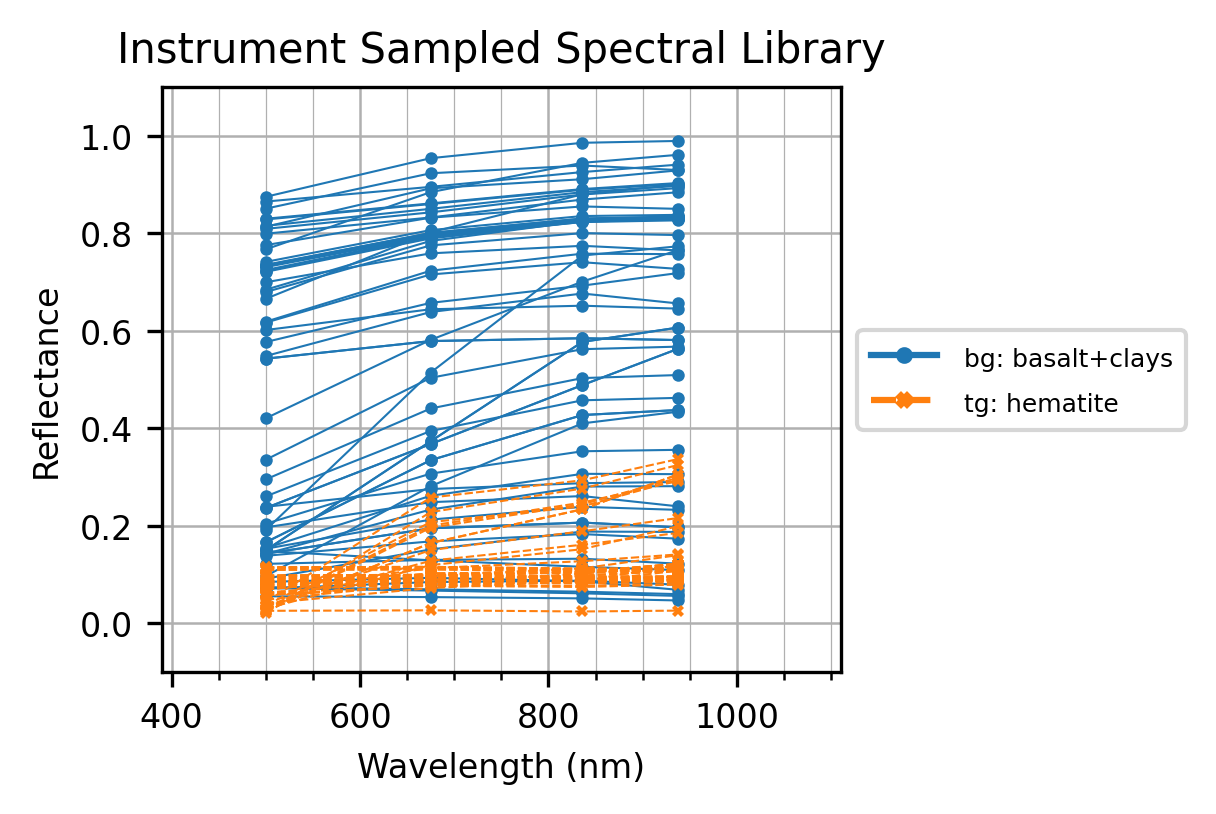

In [15]:
obs.plot_profiles(categories_only=True)

Original File link: [../projects/stabbins2024_exmpc_hematite_paper_data_products/observation/plots/stabbins2024_exmpc_hematite_paper_walkthrough_exm_pc_geol_all_entries_all.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/observation/plots/stabbins2024_exmpc_hematite_paper_walkthrough_exm_pc_geol_all_entries_all.png)

## Dataset 2



Instrument-Resampled Material Collection: [../projects/stabbins2024_exmpc_hematite_paper_data_products/observation/tables/observation.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/observation/tables/observation.csv)

In [16]:
obs.main_df.head()

Category   Sample ID Mineral Name  \
Data ID                                                   
HEM 103_888       tg: hematite     HEM 103     hematite   
HEM 103_f1_15930  tg: hematite  HEM 103_f1     hematite   
HEM101_7928       tg: hematite      HEM101     hematite   
HEM101_f1_11183   tg: hematite   HEM101_f1     hematite   
HEM102_f1_12805   tg: hematite   HEM102_f1     hematite   

                                                 Sample Description  \
Data ID                                                               
HEM 103_888                                         Many purple XLs   
HEM 103_f1_15930               9.6. Other oxides: ASD spectra (PSF)   
HEM101_7928                          Pigment mixed with linseed oil   
HEM101_f1_11183   9.6. Other oxides: RELAB + Nicolet / Merged RE...   
HEM102_f1_12805   9.6. Other oxides: RELAB + Nicolet / Merged RE...   

                                  Date Added Viewing Geometry  \
Data ID                                                         
HEM 103_888       2022-04-27 19:59:56.925217          I30_ e0   
HEM 103_f1_15930  2022-04-27 19:59:56.954227           30 / 0   
HEM101_7928       2022-04-27 19:59:56.981127          I30_ e0   
HEM101_f1_11183   2022-04-27 19:59:57.009525           30 / 0   
HEM102_f1_12805   2022-04-27 19:59:57.090445           30 / 0   

                 Other Information Formula Composition      Resolution  \
Data ID                                                                  
HEM 103_888                    NaN     NaN         NaN  2@350-7@2500nm   
HEM 103_f1_15930               NaN     NaN         NaN    2@350-7@2500   
HEM101_7928                    NaN     NaN         NaN  2@350-7@2500nm   
HEM101_f1_11183                NaN     NaN         NaN               5   
HEM102_f1_12805                NaN     NaN         NaN               5   

                 Grain Size Locality  \
Data ID                                
HEM 103_888          <45 um      NaN   
HEM 103_f1_15930        <45      NaN   
HEM101_7928           Paint      NaN   
HEM101_f1_11183         <45      NaN   
HEM102_f1_12805         <45      NaN   

                                                 Database of Origin  \
Data ID                                                               
HEM 103_888       University of Winnipeg Spectrophotometer Facility   
HEM 103_f1_15930  University of Winnipeg Spectrophotometer Facility   
HEM101_7928       University of Winnipeg Spectrophotometer Facility   
HEM101_f1_11183   University of Winnipeg Spectrophotometer Facility   
HEM102_f1_12805   University of Winnipeg Spectrophotometer Facility   

                 Reflectance       500       675       836       937  
Data ID                                                               
HEM 103_888              ---  0.058024  0.078090  0.089722  0.095936  
HEM 103_f1_15930         ---  0.058024  0.078090  0.089722  0.095936  
HEM101_7928              ---  0.020814  0.228485  0.276693  0.324694  
HEM101_f1_11183          ---  0.044400  0.258192  0.293660  0.336949  
HEM102_f1_12805          ---  0.069039  0.113393  0.127672  0.141445

## Figure 1. C

We show the transmission profiles of the instrument spectral channels in a simple plot:

Plotting Instrument Transmission...
Plots exported to ../projects/cassis_sptk_development/instrument


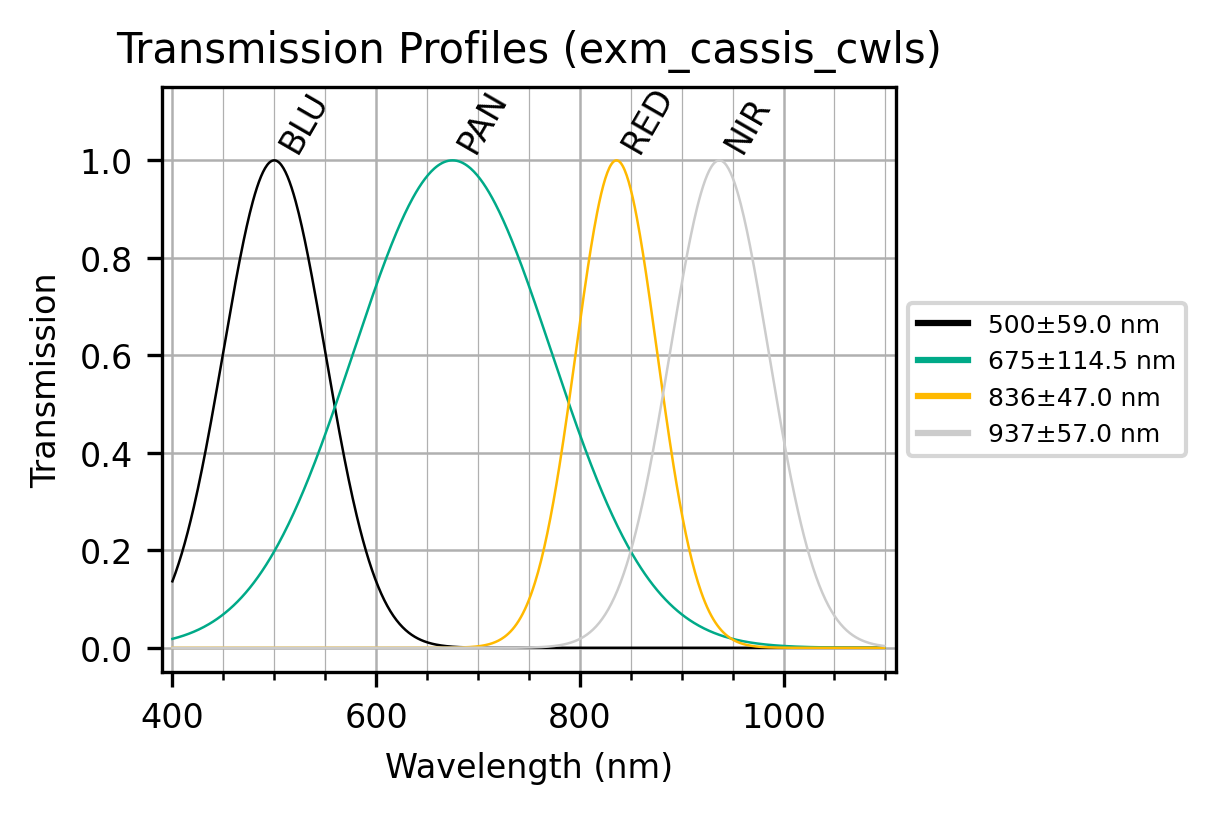

In [17]:
inst.plot_filter_profiles()

Original File link: [../projects/stabbins2024_exmpc_hematite_paper_data_products/instrument/exm_pc_geol.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/instrument/exm_pc_geol.png)

## Dataset 3



Instrument Transmission file: [../projects/stabbins2024_exmpc_hematite_paper_data_products/instrument/instrument.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/instrument/instrument.csv)

In [18]:
inst.main_df.head()

cwl  fwhm         400.0         401.0         402.0         403.0  \
filter_id                                                                      
BLU        500   118  1.363746e-01  1.418902e-01  1.475700e-01  1.534160e-01   
PAN        675   229  1.830484e-02  1.884425e-02  1.939750e-02  1.996489e-02   
RED        836    94  1.202897e-26  1.581212e-26  2.077204e-26  2.727065e-26   
NIR        937   114  1.847941e-27  2.323597e-27  2.920439e-27  3.669019e-27   

                  404.0         405.0         406.0         407.0  ...  \
filter_id                                                          ...   
BLU        1.594301e-01  1.656140e-01  1.719691e-01  1.784970e-01  ...   
PAN        2.054669e-02  2.114322e-02  2.175476e-02  2.238162e-02  ...   
RED        3.577989e-26  4.691481e-26  6.147635e-26  8.050699e-26  ...   
NIR        4.607512e-27  5.783590e-27  7.256766e-27  9.101299e-27  ...   

                 1090.0        1091.0        1092.0        1093.0  \
filter_id                                                           
BLU        7.587062e-31  5.996332e-31  4.737232e-31  3.741025e-31   
PAN        1.104702e-04  1.057191e-04  1.011617e-04  9.679044e-05   
RED        1.596547e-09  1.360752e-09  1.159054e-09  9.866330e-10   
NIR        6.758705e-03  6.329989e-03  5.925937e-03  5.545309e-03   

                 1094.0        1095.0        1096.0        1097.0  \
filter_id                                                           
BLU        2.953136e-31  2.330254e-31  1.838019e-31  1.449185e-31   
PAN        9.259828e-05  8.857833e-05  8.472392e-05  8.102867e-05   
RED        8.393342e-10  7.135780e-10  6.062829e-10  5.147976e-10   
NIR        5.186913e-03  4.849610e-03  4.532307e-03  4.233956e-03   

                 1098.0        1099.0  
filter_id                              
BLU        1.142153e-31  8.998124e-32  
PAN        7.748638e-05  7.409111e-05  
RED        4.368425e-10  3.704594e-10  
NIR        3.953557e-03  3.690151e-03  

[4 rows x 702 columns]

## Figure 1. D

Note that in the paper, we collect the legends of Figures 1. A - C, that have been generated with the plots here.

Each of the objects, ```MaterialCollection```, ```Instrument```, ```Observation``` stores the dataset in a dataframe, that can be accessed by ```[object].main_df```, as printed below.

The data is also exported, as displaye in the dataframe, to csv file, that are stored in the project directory.

# Theory and Method

The process of finding minimal filter combinations that separate the classes of our Material Collection involves, as described in the Theory and Method section of the paper, the following steps:

1. Computing Spectral Parameter values for our Sampled Material Collection
2. Listing Spectral Parameter Combination Pair-spaces
3. Splitting the Sample Material Collection into Test and Train datasets
4. Fitting Linear Disciminants to the Sampled Material Collection Train dataset, in each Spectral Parameter Combination space
5. Evaluating the Fisher Ratio of the Linear Discriminant for each Spectral Parameter Combination space
6. Evaluating the Accuracy of the Linear Discriminant for each Spectral Parameeter Combination space

Here we demonstate how to perform these steps using ```sptk```.

## Computing Spectral Parameters

Our set of spectral parameters consists of 4 types: Ratio, Slope, Band-Depth and
Shoulder-Height. These are the 4 main spectral parameter types defined for 
analysing CRISM spectral imaging data (Pelkey et al., 2007; Viviano-Beck et al.,
2014), with the exception of doublet/two-band spectral parameters that measure 
features that typical multispectral VNIR systems are not capable of resolving.

The spectral parameters are computed and held using the SpectralParameters object:

In [19]:
from sptk.spectral_parameters import SpectralParameters

This is initialised by passing the observation data to the SpectralParameters constructor:

In [20]:
sps = SpectralParameters(
        observation=obs, # the Observation object, hosting the instrument-sampled spectral library
        load_existing=False, # if True, load pre-computed spectral parameters from the project directory
        export_df=True) # if True, export the spectral parameter values to the project directory

Building new Spectral Parameters DataFramefor cassis_sptk_development
SpectralParameters export complete.


The spectral parameters are then computed:

In [21]:
sps.compute_spectral_parameters()

SpectralParameters export complete.


The main DataFrame for the SpectralParameters object stores the spectral parameter value for each material entry and each spectral parameter. We export the updated spectral paraemters table:

In [22]:
sps.export_main_df()

SpectralParameters export complete.


## Dataset 4


As for the previous classes, the ```SpectralParameters``` object also hosts the data in a DatafFrame, accessed via the ```.main_df``` attribute, and exported to csv.

Original Material Collection Spectral Parameters: [../projects/stabbins2024_exmpc_hematite_paper_data_products/spectral_parameters/tables/spectral_parameters.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spectral_parameters/tables/spectral_parameters.csv)

In [23]:
sps.main_df.head()

Category   Sample ID Mineral Name  \
Data ID                                                   
HEM 103_888       tg: hematite     HEM 103     hematite   
HEM 103_f1_15930  tg: hematite  HEM 103_f1     hematite   
HEM101_7928       tg: hematite      HEM101     hematite   
HEM101_f1_11183   tg: hematite   HEM101_f1     hematite   
HEM102_f1_12805   tg: hematite   HEM102_f1     hematite   

                                                 Sample Description  \
Data ID                                                               
HEM 103_888                                         Many purple XLs   
HEM 103_f1_15930               9.6. Other oxides: ASD spectra (PSF)   
HEM101_7928                          Pigment mixed with linseed oil   
HEM101_f1_11183   9.6. Other oxides: RELAB + Nicolet / Merged RE...   
HEM102_f1_12805   9.6. Other oxides: RELAB + Nicolet / Merged RE...   

                                  Date Added Viewing Geometry  \
Data ID                                                         
HEM 103_888       2022-04-27 19:59:56.925217          I30_ e0   
HEM 103_f1_15930  2022-04-27 19:59:56.954227           30 / 0   
HEM101_7928       2022-04-27 19:59:56.981127          I30_ e0   
HEM101_f1_11183   2022-04-27 19:59:57.009525           30 / 0   
HEM102_f1_12805   2022-04-27 19:59:57.090445           30 / 0   

                 Other Information Formula Composition      Resolution  ...  \
Data ID                                                                 ...   
HEM 103_888                    NaN     NaN         NaN  2@350-7@2500nm  ...   
HEM 103_f1_15930               NaN     NaN         NaN    2@350-7@2500  ...   
HEM101_7928                    NaN     NaN         NaN  2@350-7@2500nm  ...   
HEM101_f1_11183                NaN     NaN         NaN               5  ...   
HEM102_f1_12805                NaN     NaN         NaN               5  ...   

                 S_675_937 S_836_937 BD_500_675_836 BD_500_675_937  \
Data ID                                                              
HEM 103_888       0.000068  0.000062      -0.047711      -0.066707   
HEM 103_f1_15930  0.000068  0.000062      -0.047711      -0.066707   
HEM101_7928       0.000367  0.000475      -0.482856      -0.603348   
HEM101_f1_11183   0.000301  0.000429      -0.481967      -0.598187   
HEM102_f1_12805   0.000107  0.000136      -0.138750      -0.156669   

                  BD_500_836_937  BD_675_836_937  SH_500_675_836  \
Data ID                                                            
HEM 103_888            -0.029235       -0.007478        0.045538   
HEM 103_f1_15930       -0.029235       -0.007478        0.045538   
HEM101_7928            -0.087371        0.037942        0.325626   
HEM101_f1_11183        -0.090317        0.042169        0.325221   
HEM102_f1_12805        -0.023750        0.022651        0.121844   

                  SH_500_675_937  SH_500_836_937  SH_675_836_937  
Data ID                                                           
HEM 103_888             0.062536        0.028404        0.007422  
HEM 103_f1_15930        0.062536        0.028404        0.007422  
HEM101_7928             0.376305        0.080351       -0.039439  
HEM101_f1_11183         0.374291        0.082836       -0.044026  
HEM102_f1_12805         0.135448        0.023199       -0.023176  

[5 rows x 44 columns]

## Spectral Parameter Combinations

From the spectral parameter dataset, we then produce a list of combinations.

For each pair, we use LDA to find the linear combination of the 2 spectral
parameters that best separates the target from the background in the dataset.

We then check the accuracy of classification on each pair, and use this to
compare all the spectral parameter combinations.

We generate the combination list, and host the LDA classifier data, in a 
SpectralParameterCombinationClassifier (SPCC):

In [24]:
from sptk.spectral_parameter_combination_classifier import SpectralParameterCombinationClassifier as SPCC

The object is initialised by passing the spectral parameters dataset, and setting
the number of entries in each combination (k_combinations). Here we limit 
ourselves to 2 - i.e. pairs only.

In [25]:
spc = SPCC(
        spectral_parameters=sps, # SpectralParameter object containing the value of each spectral parameter for each entry of the spectral library
        k_combinations=2, # the number of spectral parameters to use in each spectral parameter combination
        load_existing=False) # if True, export the data to the project directory

Building new SpectralParameterCombinationClassifier DataFrame for cassis_sptk_development


The SPCC object assigns an identifier to each spectral parameter combination, and
stores the names of the component spectral parameters, the instrument channels 
required to construct them, and the number of unique filters, in a dataframe,
of the following format:

In [26]:
spc.main_df.head()

sp_0       sp_1 fltrs_0   fltrs_1  n_uniq_fltrs  uniq_fltrs
spc_id                                                             
0       R500       R500     BLU       BLU             1       (BLU)
1       R500       R675     BLU       PAN             2  (BLU, PAN)
2       R500       R836     BLU       RED             2  (RED, BLU)
3       R500       R937     BLU       NIR             2  (NIR, BLU)
4       R500  R_500_675     BLU  BLU, PAN             2  (BLU, PAN)

Here we only show a small number, the total number of spectral parameter 
combinations studied here, and contained in the dataframe, is:

In [27]:
len(spc.main_df)

465

## Fitting the Linear Discriminant Classifiers

Now that we have prepared a list of spectral parameter combinations (SPCs), and we have evaluated all of the component spectral parameters, we are ready to perform Linear Discriminant Analysis on the SPCs.

The commonly used LDA toolkit provided by the Python library *scikit-learn* is not suitable for solving multiple LDA problems in parallel. For efficiency,
we have implemented a bespoke LDA algorithm that is capable of solving for all SPCs in parallel.

This process is run multiple times, handled by the ```SPCC.fit_lda_repeat_holdout()``` method, but here we will step through a single iteration for illustration.

We split the spectral parameters data into testing and training datasets:

In [28]:
train_sps, test_sps = sps.train_test_random_split(
    test_size=0.2, # the percentage of the dataset to set aside for testing
    seed = 1) # the seed for the random sp[lit, for reproducibility

and train the LDA classifiers on the training dataset:

In [29]:
lda_fits = spc.fit_lda(train_sps)

The fitting process performs the following steps on all spectral parameter combinations in paralllel:

 1. computes the within-class scatter matrix,
 2. computes the between-class scatter matrix,
 3. computes the projection matrix, by solving the generalised eigen-problem,
 4. computes the decision boundary on the projected data

The model parameters are appended to the list of spectral parameter combinations,
e.g.:

In [30]:
lda_fits.head()

lda_score  lda_a_0_1  lda_a_1_1  lda_boundary_1  lda_tg_gt_bg_1
spc_id                                                                 
0        1.037723   1.000000   0.000000        0.276151           False
1        1.699856   0.481149  -0.876639       -0.165313            True
2        1.888798   0.319181  -0.947694       -0.262654            True
3        1.666195   0.155122  -0.987895       -0.333375            True
4        1.196089   0.959586  -0.281415        0.047151           False

Note that these results are appended to the spc.main_df:

In [31]:
spc.main_df.head()

sp_0       sp_1 fltrs_0   fltrs_1  n_uniq_fltrs  uniq_fltrs  \
spc_id                                                                
0       R500       R500     BLU       BLU             1       (BLU)   
1       R500       R675     BLU       PAN             2  (BLU, PAN)   
2       R500       R836     BLU       RED             2  (RED, BLU)   
3       R500       R937     BLU       NIR             2  (NIR, BLU)   
4       R500  R_500_675     BLU  BLU, PAN             2  (BLU, PAN)   

        lda_score  lda_a_0_1  lda_a_1_1  lda_boundary_1  lda_tg_gt_bg_1  
spc_id                                                                   
0        1.037723   1.000000   0.000000        0.276151           False  
1        1.699856   0.481149  -0.876639       -0.165313            True  
2        1.888798   0.319181  -0.947694       -0.262654            True  
3        1.666195   0.155122  -0.987895       -0.333375            True  
4        1.196089   0.959586  -0.281415        0.047151           False

### Classifier Accuracy

Then we make predictions on the test dataset using these learned classifiers.

In [32]:
predictions = spc.binary_classifier(test_sps)

and then we test the accuracy of these predictions:

In [33]:
lda_acc = spc.binary_classifier_accuracy(predictions, test_sps.main_df.Category)

In [34]:
lda_acc.head()

lda_acc_1  lda_ppv_1  lda_tpr_1  lda_tnr_1  lda_fpr_1
spc_id                                                       
0        0.708333   0.631579        1.0   0.416667   0.583333
1        0.708333   0.631579        1.0   0.416667   0.583333
2        0.708333   0.631579        1.0   0.416667   0.583333
3        0.708333   0.631579        1.0   0.416667   0.583333
4        0.708333   0.631579        1.0   0.416667   0.583333

again, this information has been appended to the dataframe:

In [35]:
spc.main_df.head()

sp_0       sp_1 fltrs_0   fltrs_1  n_uniq_fltrs  uniq_fltrs  \
spc_id                                                                
0       R500       R500     BLU       BLU             1       (BLU)   
1       R500       R675     BLU       PAN             2  (BLU, PAN)   
2       R500       R836     BLU       RED             2  (RED, BLU)   
3       R500       R937     BLU       NIR             2  (NIR, BLU)   
4       R500  R_500_675     BLU  BLU, PAN             2  (BLU, PAN)   

        lda_score  lda_a_0_1  lda_a_1_1  lda_boundary_1  lda_tg_gt_bg_1  \
spc_id                                                                    
0        1.037723   1.000000   0.000000        0.276151           False   
1        1.699856   0.481149  -0.876639       -0.165313            True   
2        1.888798   0.319181  -0.947694       -0.262654            True   
3        1.666195   0.155122  -0.987895       -0.333375            True   
4        1.196089   0.959586  -0.281415        0.047151           False   

        lda_acc_1  lda_ppv_1  lda_tpr_1  lda_tnr_1  lda_fpr_1  
spc_id                                                         
0        0.708333   0.631579        1.0   0.416667   0.583333  
1        0.708333   0.631579        1.0   0.416667   0.583333  
2        0.708333   0.631579        1.0   0.416667   0.583333  
3        0.708333   0.631579        1.0   0.416667   0.583333  
4        0.708333   0.631579        1.0   0.416667   0.583333

## Repeat Holdout Method

We repeat this process $k$ times, and aggregate the results of the LDA scores
and classification accuracy metrics, and also record the variance.

Note, depending on your computer specifications, 500 trials should take ~20 - 40 minutes.

If loading a dataset computed previously, it can take 1 - 3 minutes to load the large (~12 Gb) csv file.

Note, the repeat-holdout implementation does not use seed values when performing random test-train splitting, so each run of ```fit_lda_repeat_holdout``` may produce results with some variance. However, we have found that stable results are typically produced over the order of ~500 repeat trials.

For precise reproduction of the study, the ```spc_trials.csv``` file from the [study results] directory should be copied into the ```spc_classifier/table``` directory, and the following cell run with ```load_existing=True```. This will load in the large set of results table, that logs the complete LDA fitting results for each spectral parameter combination and each of the 500 trials.

In [37]:
stats_df, trials_df = spc.fit_lda_repeat_holdout(
    sps, # the SpectralParameters object, that hosts the data that is randomply split
    k_trials=10, # the number of repeat-holdout trials to perform
    seed=1,
    export_df=False, # if True, export the data results to the project directory
    load_existing=False) # if True, load pre-computed results from the project directory

Running trial 0 of 10...
Running trial 1 of 10...
Running trial 2 of 10...
Running trial 3 of 10...
Running trial 4 of 10...
Running trial 5 of 10...
Running trial 6 of 10...
Running trial 7 of 10...
Running trial 8 of 10...
Running trial 9 of 10...
SpectralParameterCombinationClassifier export complete.


/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:569: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  var_spc = trials_df.groupby(level='metric', axis=1).std()**2


The trials_df dataframe logs all of the results of the repeat trials, for example here we show the first 3 results of the Fisher Ratio and Accuracy scores:

In [38]:
exmpl_trials = trials_df.loc[:,(('lda_score', 'mean'),(1,2,3))]
exmpl_trials.head()

/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_20291/1810775136.py:1: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  exmpl_trials = trials_df.loc[:,(('lda_score', 'mean'),(1,2,3))]


metric lda_score                    
trial          1         2         3
spc_id                              
0       0.793725  0.922327  0.893734
1       1.241071  1.269924  1.389975
2       1.342929  1.344072  1.525216
3       1.183198  1.211999  1.374239
4       0.902739  1.006316  1.007793

In [39]:
exmpl_trials = trials_df.loc[:,(('lda_score', 'mean'),(1,2,3))]
exmpl_trials.head()

/var/folders/w4/44k32f413dd82lxmtw9456w80000gp/T/ipykernel_20291/1810775136.py:1: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  exmpl_trials = trials_df.loc[:,(('lda_score', 'mean'),(1,2,3))]


metric lda_score                    
trial          1         2         3
spc_id                              
0       0.793725  0.922327  0.893734
1       1.241071  1.269924  1.389975
2       1.342929  1.344072  1.525216
3       1.183198  1.211999  1.374239
4       0.902739  1.006316  1.007793

and the stats_df logs the mean and variance of these across the repeat trials:

In [40]:
stats_df[['lda_score','lda_acc_1']].head()

metric lda_score           lda_acc_1          
            mean       var      mean       var
spc_id                                        
0       0.863968  0.012851  0.800000  0.005324
1       1.240690  0.034658  0.808333  0.007407
2       1.338007  0.041903  0.833333  0.004630
3       1.202308  0.033705  0.845833  0.005806
4       0.942444  0.016292  0.800000  0.006867

In [41]:
stats_df[['lda_score','lda_acc_1']].head()

metric lda_score           lda_acc_1          
            mean       var      mean       var
spc_id                                        
0       0.863968  0.012851  0.800000  0.005324
1       1.240690  0.034658  0.808333  0.007407
2       1.338007  0.041903  0.833333  0.004630
3       1.202308  0.033705  0.845833  0.005806
4       0.942444  0.016292  0.800000  0.006867

We save the outputs of the trials, and the statistical summaries:

In [42]:
# spc.export_df(df_type='trials')

In [43]:
spc.export_df(df_type='stats')

SpectralParameterCombinationClassifier export complete.


We then use the fit_lda function to fit the spectral parameter combination 
classifiers to the entire dataset, with division,

In [44]:
_ = spc.fit_lda(sps)

We also run the accuracy evaluation over the entire dataset:

In [45]:
predictions = spc.binary_classifier(sps)
lda_acc = spc.binary_classifier_accuracy(predictions, sps.main_df.Category, apply=True)

In [46]:
spc.main_df['lda_score'].head()

spc_id
0    0.860742
1    1.174879
2    1.267183
3    1.138951
4    0.908702
Name: lda_score, dtype: float64

In [47]:
spc.main_df['lda_acc_1'].head()

spc_id
0    0.783333
1    0.850000
2    0.858333
3    0.858333
4    0.816667
Name: lda_acc_1, dtype: float64

Finally, we rank the order of each of the metrics, according to the averages over repeat-holdout, and according to the results across the entire dataset:

In [48]:
_ = spc.rank_spcs(metric='lda_acc_1', scope='mean')
_ = spc.rank_spcs(metric='lda_score', scope='mean')
_ = spc.rank_spcs(metric='lda_acc_1', scope='all-data')
_ = spc.rank_spcs(metric='lda_score', scope='all-data')

This also computes the percentile of the ranks.

We export the complete set of results:

In [49]:
complete_df = spc.export_complete_df()

# Results

The table of results can be summarised as containing the following information:

For each of 211575 Spectral Parameter Combinations, we have:
- Fitted a Linear Discriminant (a0: lda_a_0_1, a1: lda_a_1_1, b: lda_boundary_1, tg>bg:lda_tg_gt_bg_1)  
    Such that: $l = a_0p_0[x] + a_1p_1[x] - b$,  
    where $x \in \begin{cases} \text{target}\; \text{if}\; l > 0\; \text{and}\; \text{tg>bg} \; \text{or}\; l \leq 0\; \text{and}\; !\text{tg>bg} \;\\ \text{background}\; \text{otherwise} \end{cases}$  
    for entry $x$, for the spectral parameter combination composed of spectral parameters $0$ and $1$, that have values $p_0[x]$ and $p_1[x]$ for the entry $x$.
- Evaluated the mean Fisher Ratio and mean Accuracy, and associated variances, over 500 repeat trials of randomly split train and test data.
- Evaluated the Fisher Ratio and Accuracy over the entire dataset.

Here, we use these results to present:
1. The highest ranked Spectral Parameter Combinations when ranked by Mean Fisher Ratio and Mean Accuracy,
2. The highest ranked Spectral Parameter Combinations when ranked by Mean Fisher Ratio and Mean Accuracy, for a constrained number of unique constituent spectral filters,
3. Summaries of the performance of the population of spectral parameter combinations.

## Dataset 5

The results of all of the trials are stored at:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/tables/spc_trials.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/tables/spc_trials.csv)


In [50]:
spc.trials_df.head()

metric rank_lda_score_all-data pct_lda_score_all-data rank_lda_acc_1_all-data  \
trial                                                                           
spc_id                                                                          
0                        201.0              56.989247                   297.0   
1                         78.0              83.440860                   208.0   
2                         50.0              89.462366                   173.0   
3                         94.0              80.000000                   173.0   
4                        183.0              60.860215                   262.0   

metric pct_lda_acc_1_all-data rank_lda_score_mean pct_lda_score_mean  \
trial                                                                  
spc_id                                                                 
0                   36.344086               204.0          56.344086   
1                   55.483871                67.0          85.806452   
2                   63.010753                43.0          90.967742   
3                   63.010753                84.0          82.150538   
4                   43.870968               179.0          61.720430   

metric rank_lda_acc_1_mean pct_lda_acc_1_mean lda_score            ...  \
trial                                                 1         2  ...   
spc_id                                                             ...   
0                    260.0          44.301075  0.793725  0.922327  ...   
1                    241.0          48.387097  1.241071  1.269924  ...   
2                    196.0          58.064516  1.342929  1.344072  ...   
3                    172.0          63.225806  1.183198  1.211999  ...   
4                    260.0          44.301075  0.902739  1.006316  ...   

metric lda_fpr_1                                                              \
trial          1         2         3         4         5         6         7   
spc_id                                                                         
0           0.25  0.416667  0.500000  0.250000  0.583333  0.500000  0.333333   
1           0.25  0.250000  0.416667  0.083333  0.250000  0.416667  0.250000   
2           0.25  0.250000  0.416667  0.083333  0.250000  0.416667  0.250000   
3           0.25  0.250000  0.416667  0.083333  0.250000  0.416667  0.250000   
4           0.25  0.416667  0.416667  0.166667  0.583333  0.500000  0.333333   

metric                                
trial          8         9        10  
spc_id                                
0       0.583333  0.416667  0.166667  
1       0.500000  0.333333  0.083333  
2       0.500000  0.333333  0.083333  
3       0.500000  0.333333  0.083333  
4       0.583333  0.416667  0.166667  

[5 rows x 88 columns]

## Dataset 6

The statisical summaries of these results are given at:
[./spectral_parameters_studies/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/tables/spc_stats.csv](./spectral_parameters_studies/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/tables/spc_stats.csv)

In [51]:
spc.stats_df.head()

metric rank_lda_score_all-data pct_lda_score_all-data rank_lda_acc_1_all-data  \
                                                                                
spc_id                                                                          
0                        201.0              56.989247                   297.0   
1                         78.0              83.440860                   208.0   
2                         50.0              89.462366                   173.0   
3                         94.0              80.000000                   173.0   
4                        183.0              60.860215                   262.0   

metric pct_lda_acc_1_all-data rank_lda_score_mean pct_lda_score_mean  \
                                                                       
spc_id                                                                 
0                   36.344086               204.0          56.344086   
1                   55.483871                67.0          85.806452   
2                   63.010753                43.0          90.967742   
3                   63.010753                84.0          82.150538   
4                   43.870968               179.0          61.720430   

metric rank_lda_acc_1_mean pct_lda_acc_1_mean lda_score            ...  \
                                                   mean       var  ...   
spc_id                                                             ...   
0                    260.0          44.301075  0.863968  0.012851  ...   
1                    241.0          48.387097  1.240690  0.034658  ...   
2                    196.0          58.064516  1.338007  0.041903  ...   
3                    172.0          63.225806  1.202308  0.033705  ...   
4                    260.0          44.301075  0.942444  0.016292  ...   

metric lda_acc_1           lda_ppv_1           lda_tpr_1           lda_tnr_1  \
            mean       var      mean       var      mean       var      mean   
spc_id                                                                         
0       0.800000  0.005324  0.721540  0.006023  1.000000  0.000000  0.600000   
1       0.808333  0.007407  0.767871  0.008919  0.900000  0.012037  0.716667   
2       0.833333  0.004630  0.778960  0.007532  0.950000  0.003395  0.716667   
3       0.845833  0.005806  0.782459  0.007807  0.975000  0.003164  0.716667   
4       0.800000  0.006867  0.727254  0.007346  0.983333  0.002778  0.616667   

metric           lda_fpr_1            
             var      mean       var  
spc_id                                
0       0.021296  0.400000  0.021296  
1       0.018827  0.283333  0.018827  
2       0.018827  0.283333  0.018827  
3       0.018827  0.283333  0.018827  
4       0.023457  0.383333  0.023457  

[5 rows x 24 columns]

## Dataset 7

Complete set of results, giving, for each spectral parameter combination, the details of the linear discriminant classifier, the unique filters used, and the Fisher Ratio and Classification Accuracy results averaged across the repeat-holdout, and across the complete dataset.

Original Complete Results File Link:
[./spectral_parameters_studies/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/tables/complete_results.csv](./spectral_parameters_studies/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/tables/complete_results.csv)

In [52]:
complete_df.head()

sp_x       sp_y       a_x       a_y  boundary  tg_gt_bg  NUC  \
spc_id                                                                 
0       R500       R500  1.000000  0.000000  0.264813     False    1   
1       R500       R675  0.433083 -0.901354 -0.175959      True    2   
2       R500       R836  0.251734 -0.967796 -0.271301      True    2   
3       R500       R937  0.002821 -0.999996 -0.358021      True    2   
4       R500  R_500_675  0.981102 -0.193489  0.106539     False    2   

              UC      FR_D  FR_D Rank  ...     TPR_D     FPR_D    ACC_mu  \
spc_id                                 ...                                 
0            BLU  0.860742      201.0  ...  0.433333  0.433333  0.800000   
1       BLU, PAN  1.174879       78.0  ...  0.266667  0.266667  0.808333   
2       RED, BLU  1.267183       50.0  ...  0.266667  0.266667  0.833333   
3       NIR, BLU  1.138951       94.0  ...  0.283333  0.283333  0.845833   
4       BLU, PAN  0.908702      183.0  ...  0.366667  0.366667  0.800000   

         ACC_var  ACC_mu Rank  ACC_mu P.R.    TPR_mu   TPR_var    FPR_mu  \
spc_id                                                                     
0       0.005324        260.0    44.301075  1.000000  0.000000  0.400000   
1       0.007407        241.0    48.387097  0.900000  0.012037  0.283333   
2       0.004630        196.0    58.064516  0.950000  0.003395  0.283333   
3       0.005806        172.0    63.225806  0.975000  0.003164  0.283333   
4       0.006867        260.0    44.301075  0.983333  0.002778  0.383333   

         FPR_var  
spc_id            
0       0.021296  
1       0.018827  
2       0.018827  
3       0.018827  
4       0.023457  

[5 rows x 28 columns]

## Performance of Top Ranked SPCs on Complete Dataset

## Overall Top Ranked Spectral Parameter Combinations

As reported in the paper here are the Spectral Parameter Combinations that yield the highest mean Fisher Ratio and mean Accuracy scores after the repeat-holdout trials.

## Figure 2. A & C

#### Rank by Mean Fisher Ratio

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:927: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = self.main_df[r_m_s].sort_values(


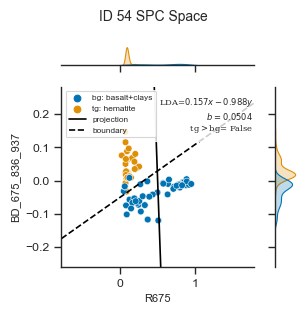

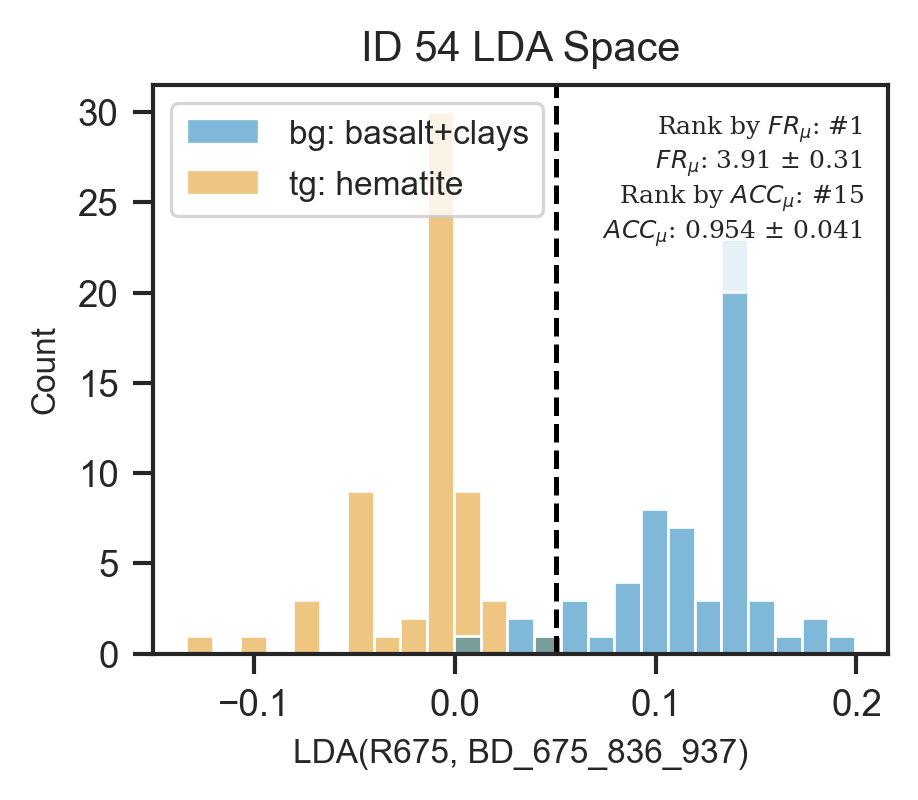

In [53]:
top_fr_spc_id, _ = spc.top_ranks(metric='lda_score', scope='mean', top_n=1, n_uniq_fltrs=None)
top_fr_stats, top_fr_sps = spc.plot_top_ranks(spectral_parameters=sps, metric='lda_score', top_n=1, n_uniq_fltrs=None, scope='mean')

In [54]:
top_fr_stats

metric rank_lda_score_mean lda_score           rank_lda_acc_1_mean lda_acc_1  \
                                mean       var                          mean   
spc_id                                                                         
54                     1.0  3.906049  0.098535                15.0  0.954167   

metric            
             var  
spc_id            
54      0.001717

In [55]:
top_fr_sps

sp_0            sp_1 fltrs_0        fltrs_1  n_uniq_fltrs  \
spc_id                                                              
54      R675  BD_675_836_937     PAN  PAN, RED, NIR             3   

             uniq_fltrs  lda_a_0_1  lda_a_1_1  lda_boundary_1  lda_tg_gt_bg_1  
spc_id                                                                         
54      (RED, PAN, NIR)   0.156801   -0.98763        0.050448           False

### Figure 2. A File Link:

Original File Link for plot in SPC Space:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_4_rank_lda_score-mean_1_R_440_840_v_R_500_740.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_4_rank_lda_score-mean_1_R_440_840_v_R_500_740.png)  

### Figure 2. C Links

Original File Link for plot in LDA Space:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_4_rank_lda_score-mean_1_R_440_840_v_R_500_740.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_4_rank_lda_score-mean_1_R_440_840_v_R_500_740_LDA.png)  

## Dataset 8

### Dataset for Figure 2. A

Original File Link for data in SPC Space:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_4_rank_lda_score-mean_1_R_440_840_v_R_500_740_data.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_4_rank_lda_score-mean_1_R_440_840_v_R_500_740_data.csv)  

## Dataset 9.

### Dataset for Figure 2. C

Original File Link for data in LDA Space:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_4_rank_lda_score-mean_1_R_440_840_v_R_500_740_LDA_data.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_4_rank_lda_score-mean_1_R_440_840_v_R_500_740_LDA_data.csv)  

## Figure 2. B & D

#### Rank by Mean Accuracy

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:927: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = self.main_df[r_m_s].sort_values(


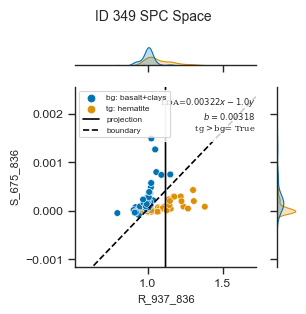

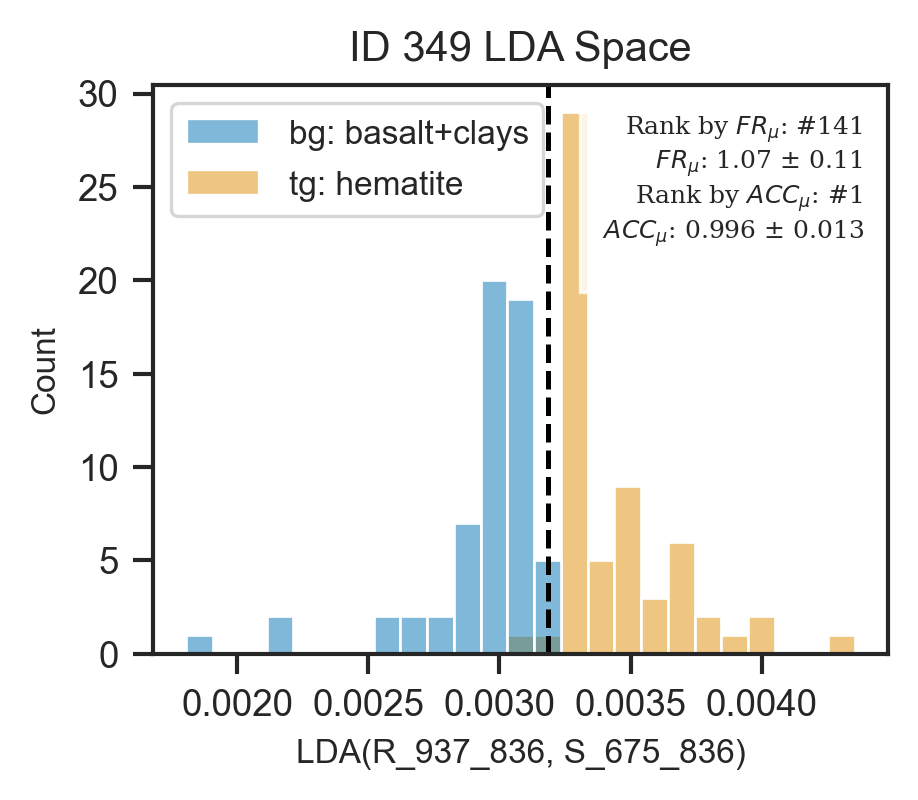

In [56]:
top_acc_spc_id, _ = spc.top_ranks(metric='lda_acc_1', scope='mean', top_n=1, n_uniq_fltrs=None)
top_acc_stats, top_acc_sps = spc.plot_top_ranks(spectral_parameters=sps, metric='lda_acc_1', top_n=1, n_uniq_fltrs=None, scope='mean')

In [57]:
top_acc_stats

metric rank_lda_score_mean lda_score           rank_lda_acc_1_mean lda_acc_1  \
                                mean       var                          mean   
spc_id                                                                         
349                  141.0  1.068423  0.011059                 1.0  0.995833   

metric            
             var  
spc_id            
349     0.000174

In [58]:
top_acc_sps

sp_0       sp_1   fltrs_0   fltrs_1  n_uniq_fltrs  \
spc_id                                                           
349     R_937_836  S_675_836  NIR, RED  PAN, RED             3   

             uniq_fltrs  lda_a_0_1  lda_a_1_1  lda_boundary_1  lda_tg_gt_bg_1  
spc_id                                                                         
349     (RED, PAN, NIR)   0.003216  -0.999995        0.003185            True

### Figure 2. B Links

Original File Link for plot in SPC Space:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_6_rank_lda_acc_1-mean_1_BD_440_780_1000_v_BD_530_840_900.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_6_rank_lda_acc_1-mean_1_BD_440_780_1000_v_BD_530_840_900.png)  

### Figure 2. D Links

Original File Link for plot in LDA Space:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_6_rank_lda_acc_1-mean_1_BD_440_780_1000_v_BD_530_840_900_LDA.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_6_rank_lda_acc_1-mean_1_BD_440_780_1000_v_BD_530_840_900_LDA.png)  

## Dataset 10

### Dataset for Figure 2. B

Original File Link for data in SPC Space:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_6_rank_lda_acc_1-mean_1_BD_440_780_1000_v_BD_530_840_900_data.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_6_rank_lda_acc_1-mean_1_BD_440_780_1000_v_BD_530_840_900_data.csv)  

## Dataset 11

### Dataset for Figure 2. D

Original File Link for data in LDA Space:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_6_rank_lda_acc_1-mean_1_BD_440_780_1000_v_BD_530_840_900_data.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_6_rank_lda_acc_1-mean_1_BD_440_780_1000_v_BD_530_840_900_LDA_data.csv)  

## Top-ranked Spectral Parameter Combinations for each Number of Unique Filter Channels

We now consider the top-ranked spectral parameter combinations when the number of unique filters used to make up the spectral parameter combination (Number of Unique Channels - **NUC**) is restricted.

In [59]:
import pandas as pd

In [60]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_score'
scope = 'mean'
top_fr_mu = spc.top_spc_per_nuc(metric, scope)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


This gives us a table showing the top mean accuracy SPC for each NUC.

In [61]:
top_fr_mu

lda_score  n_uniq_fltrs            uniq_fltrs  sp_0            sp_1  \
spc_id                                                                        
59       1.296035             1                 (RED)  R836            R836   
96       2.465571             2            (RED, NIR)  R937       R_836_937   
54       3.906049             3       (RED, PAN, NIR)  R675  BD_675_836_937   
25       3.676188             4  (RED, BLU, PAN, NIR)  R500  BD_675_836_937   

        pct_lda_score       scope  
spc_id                             
59          87.311828  $FR_{\mu}$  
96          96.774194  $FR_{\mu}$  
54         100.000000  $FR_{\mu}$  
25          99.354839  $FR_{\mu}$

In [62]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_score'
scope = 'all-data'
top_fr_d = spc.top_spc_per_nuc(metric, scope)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


This gives us a table showing the top mean accuracy SPC for each NUC.

In [63]:
top_fr_d

lda_score  n_uniq_fltrs            uniq_fltrs  sp_0            sp_1  \
spc_id                                                                        
59       1.240461             1                 (RED)  R836            R836   
96       2.508176             2            (RED, NIR)  R937       R_836_937   
54       3.856954             3       (RED, PAN, NIR)  R675  BD_675_836_937   
25       3.658881             4  (RED, BLU, PAN, NIR)  R500  BD_675_836_937   

        pct_lda_score     scope  
spc_id                           
59          87.096774  $FR_{D}$  
96          97.419355  $FR_{D}$  
54         100.000000  $FR_{D}$  
25          99.354839  $FR_{D}$

## Figure 3. A

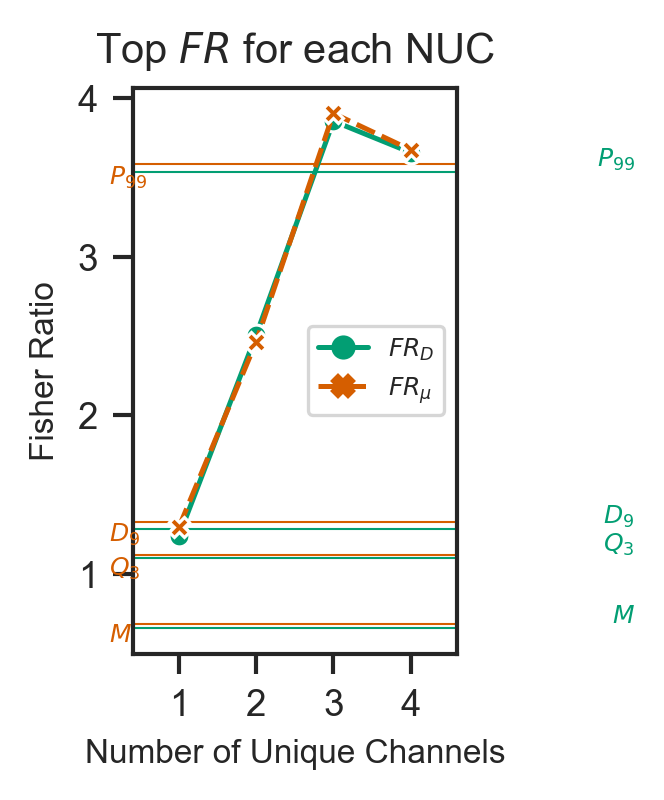

In [64]:
top_metric = pd.concat([top_fr_d, top_fr_mu])
spc.plot_top_metric_per_nuc(top_metric, metric='lda_score')

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/top_lda_score_nuc.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/top_lda_score_nuc.png)

Similarly, we can plot the mean and all-data top Accuracy scores for each NUC:

In [65]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_acc_1'
scope = 'mean'
top_acc_mu = spc.top_spc_per_nuc(metric, scope)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


This gives us a table showing the top mean accuracy SPC for each NUC.

In [66]:
top_acc_mu

lda_acc_1  n_uniq_fltrs            uniq_fltrs            sp_0  \
spc_id                                                                  
59       0.858333             1                 (RED)            R836   
96       0.933333             2            (RED, NIR)            R937   
349      0.995833             3       (RED, PAN, NIR)       R_937_836   
463      0.958333             4  (RED, BLU, PAN, NIR)  SH_500_836_937   

                  sp_1  pct_lda_acc_1        scope  
spc_id                                              
59                R836      72.688172  $ACC_{\mu}$  
96           R_836_937      82.580645  $ACC_{\mu}$  
349          S_675_836     100.000000  $ACC_{\mu}$  
463     SH_675_836_937      98.064516  $ACC_{\mu}$

In [67]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_acc_1'
scope = 'all-data'
top_acc_d = spc.top_spc_per_nuc(metric, scope)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


This gives us a table showing the top mean accuracy SPC for each NUC.

In [68]:
top_acc_d

lda_acc_1  n_uniq_fltrs            uniq_fltrs            sp_0  \
spc_id                                                                  
59       0.866667             1                 (RED)            R836   
96       0.958333             2            (RED, NIR)            R937   
302      0.991667             3       (RED, PAN, NIR)       R_836_937   
463      0.975000             4  (RED, BLU, PAN, NIR)  SH_500_836_937   

                  sp_1  pct_lda_acc_1      scope  
spc_id                                            
59                R836      69.677419  $ACC_{D}$  
96           R_836_937      92.258065  $ACC_{D}$  
302          S_675_937     100.000000  $ACC_{D}$  
463     SH_675_836_937      98.924731  $ACC_{D}$

## Figure 3. B

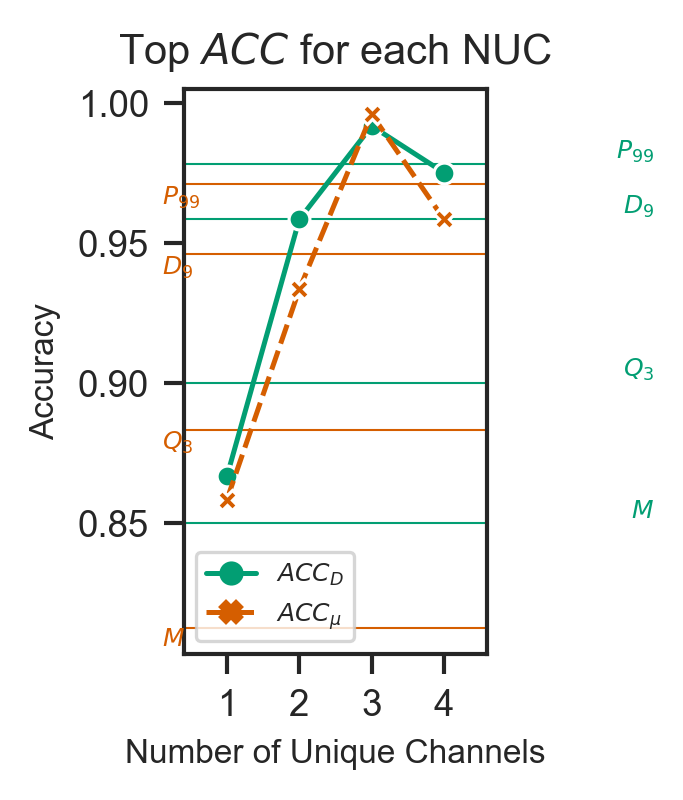

In [69]:
top_metric = pd.concat([top_acc_d, top_acc_mu])
spc.plot_top_metric_per_nuc(top_metric, metric='lda_acc_1')

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/top_lda_acc_1_nuc.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/top_lda_acc_1_nuc.png)

Note that when ranking the spectral parameters, we found that in some cases there were multiple equal entries. To log these, we can run the ```top_spc_per_nuc``` function again, with ```count_equals``` set to true:

## Dataset 12

Data for Top SPCs ranked by Mean Accuracy:

In [70]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_acc_1'
scope = 'mean'
top_acc_mu = spc.top_spc_per_nuc(metric, scope, count_equal=True)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/tables/top_lda_acc_1_mean_per_nuc.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/tables/top_lda_acc_1_mean_per_nuc.csv)

## Dataset 13

Data for Top SPCs ranked by All-Data Accuracy:

In [71]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_acc_1'
scope = 'all-data'
top_acc_d = spc.top_spc_per_nuc(metric, scope, count_equal=True)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


File link:
[../projects/stabbins2024_ess_paper_walkthrough/spc_classifier/tables/top_lda_acc_1_all-data_per_nuc.csv](../projects/stabbins2024_ess_paper_walkthrough/spc_classifier/tables/top_lda_acc_1_all-data_per_nuc.csv)

## Dataset 14

Data for Top SPCs ranked by Mean Fisher Ratio:

In [72]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_score'
scope = 'mean'
top_fr_mu = spc.top_spc_per_nuc(metric, scope, count_equal=True)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/tables/top_lda_score_mean_per_nuc.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/tables/top_lda_score_mean_per_nuc.csv)

## Dataset 15

Data for Top SPCs ranked by All-Data Fisher Ratio:

In [73]:
# get the top 1 spc for each number of unique filters, ranked by mean accuracy
metric = 'lda_score'
scope = 'all-data'
top_fr_d = spc.top_spc_per_nuc(metric, scope, count_equal=True)

/Users/sci/Documents/software/sptk/src/sptk/spectral_parameter_combination_classifier.py:942: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_ranks = top_ranks + n_u_f_df[r_m_s].sort_values(


Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/tables/top_lda_score_all-data_per_nuc.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/tables/top_lda_score_all-data_per_nuc.csv)

## Spectral Parameter Combination Population Performance

We now produce visualisations of the performance of all of the spectral parameter combinations evaluated, to show insight into the method.

### Note on Dataset to Figure 4

All data plotted in the subfigures of Figure 4 are contained in the ```complete_results.csv``` file (Dataset 7). Here we note the columns required to reproduce the plots.

## Figure 4. A

### Reciever Operating Characteristic

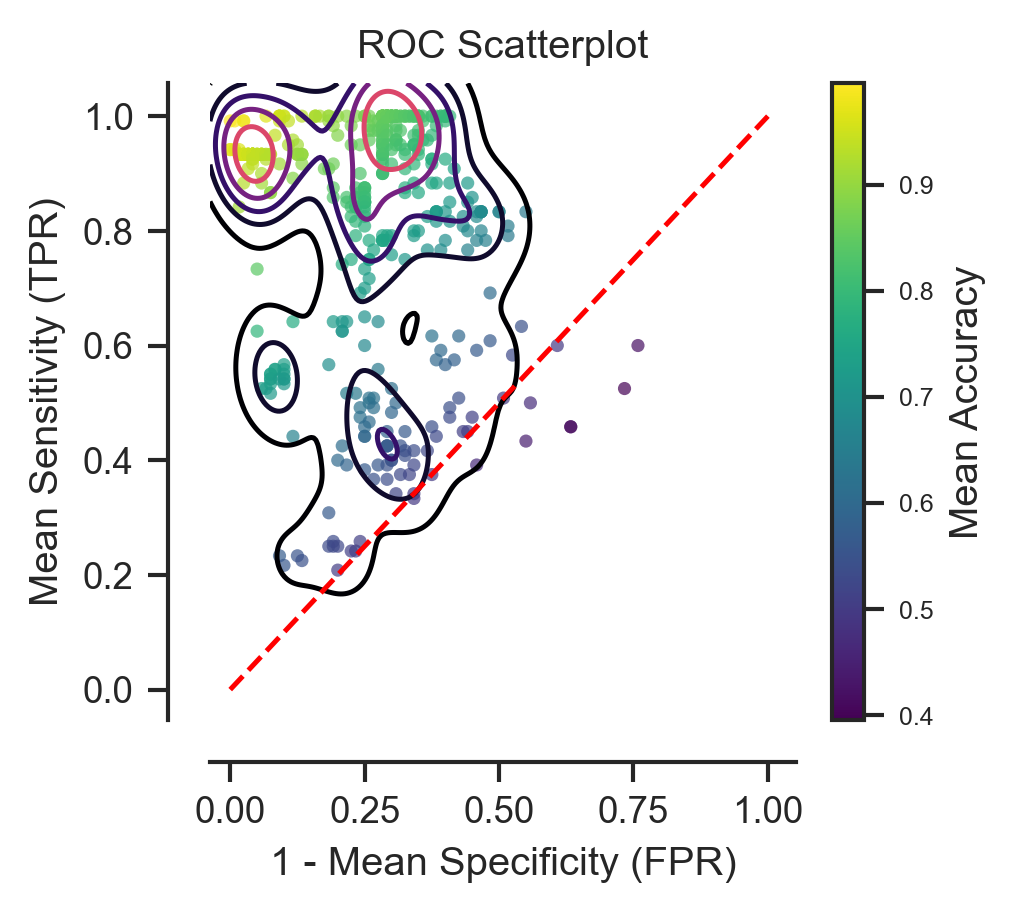

In [74]:
spc.plot_roc(noisey=False)

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/roc_scatter.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/roc_scatter.png)

## Dataset for Figure 4. A

Supplmentary data are found in the following columns of the complete_results.csv file:  
- x: ```FPR_mu```  
- y: ```TPR_mu```  
- hue: ```ACC_mu```  

that can be accessed here via ```complete_df```:

In [75]:
complete_df[['FPR_mu', 'TPR_mu', 'ACC_mu']].head()

FPR_mu    TPR_mu    ACC_mu
spc_id                              
0       0.400000  1.000000  0.800000
1       0.283333  0.900000  0.808333
2       0.283333  0.950000  0.833333
3       0.283333  0.975000  0.845833
4       0.383333  0.983333  0.800000

## Figure 4. B

### Uni- and Bi-variate Distributions of Mean Fisher Ratio and Mean Classification Accuracy

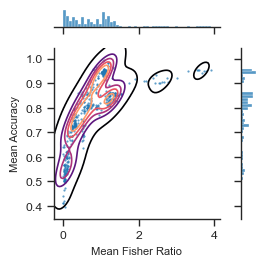

In [76]:
spc.plot_metric_vs_metric(
                ('lda_score', 'Mean Fisher Ratio'),
                ('lda_acc_1', 'Mean Accuracy'))

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/lda_acc_1_vs_lda_score.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/lda_acc_1_vs_lda_score.png)

In [77]:
r2 = spc.metric_vs_metric_regession(
                ('lda_score', 'Mean Fisher Ratio'),
                ('lda_acc_1', 'Mean Accuracy'))
print(r2)

0.2859008922992202


## Dataset for Figure 4. B

Supplmentary data are found in the following columns of the complete_results.csv file:  
- x: ```FR_mu```  
- y: ```ACC_mu```  

that can be accessed here via ```complete_df```:

In [78]:
complete_df[['FR_mu', 'ACC_mu']].head()

FR_mu    ACC_mu
spc_id                    
0       0.863968  0.800000
1       1.240690  0.808333
2       1.338007  0.833333
3       1.202308  0.845833
4       0.942444  0.800000

## Figure 4. C

### All-Data Metrics vs. Repeat-Holdout Mean Metrics

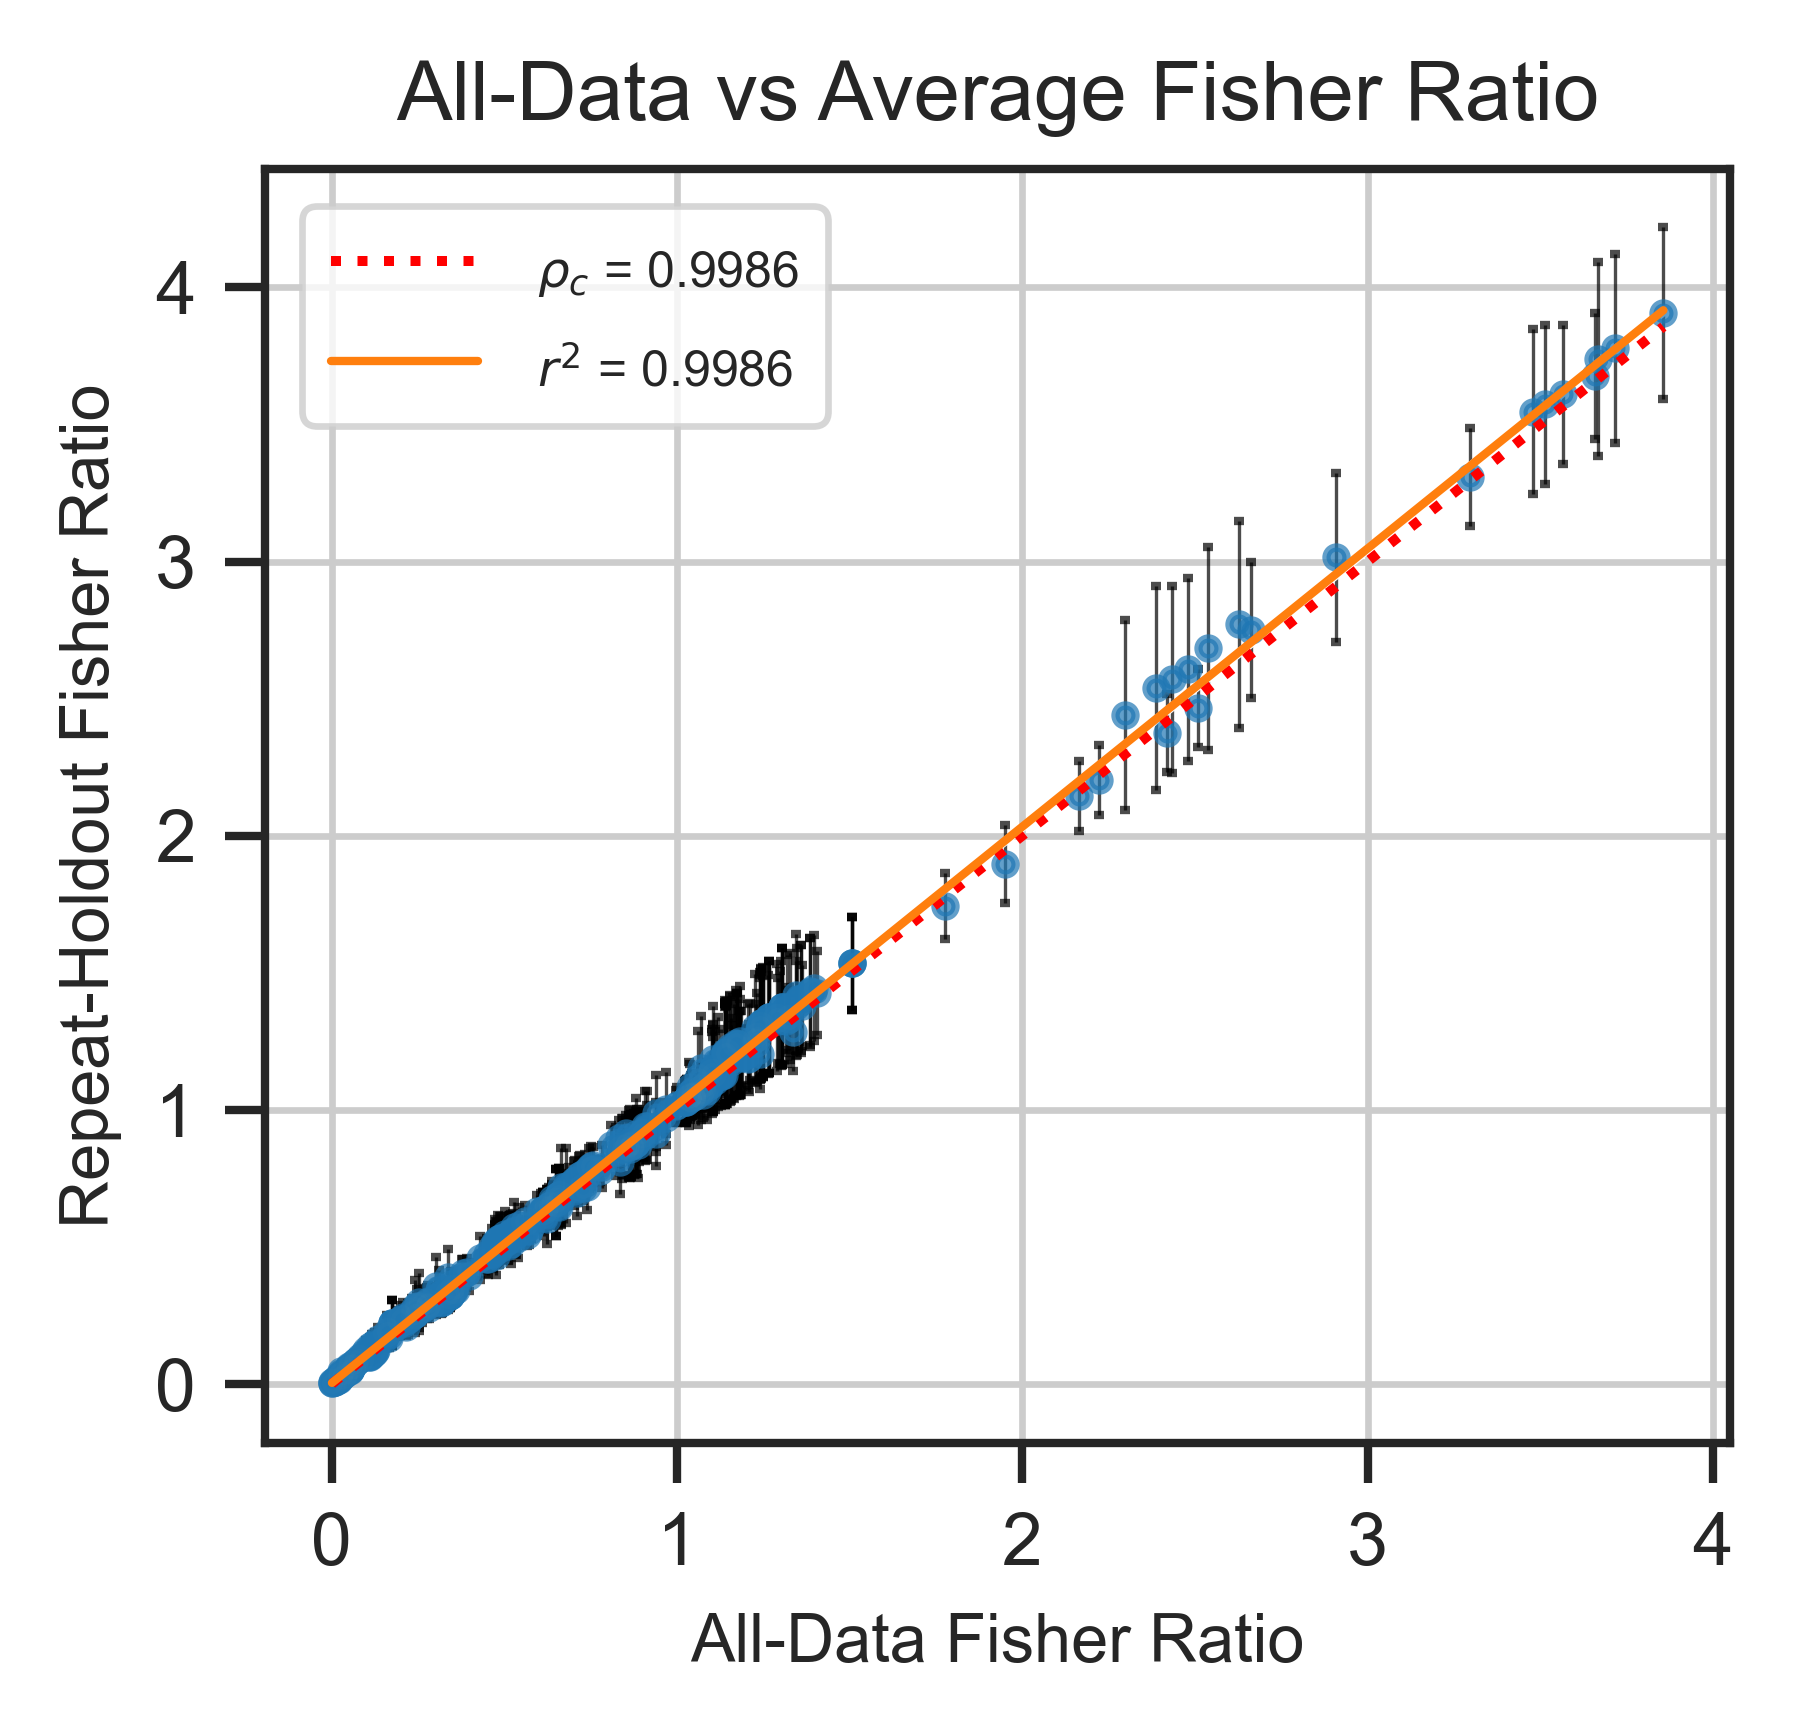

In [79]:
fr_fit = spc.plot_lda_score_stats()

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/final_vs_repeatholdout_lda_score.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/final_vs_repeatholdout_lda_score.png)

In [80]:
print(fr_fit)

{'r^2': 0.9986386762053994, 'ccc': 0.9985719033967161}


## Dataset for Figure 4. C

Supplmentary data are found in the following columns of the complete_results.csv file:  
- x: ```FR_D```  
- y: ```FR_mu```  

that can be accessed here via ```complete_df```:

In [81]:
complete_df[['FR_D', 'FR_mu']].head()

FR_D     FR_mu
spc_id                    
0       0.860742  0.863968
1       1.174879  1.240690
2       1.267183  1.338007
3       1.138951  1.202308
4       0.908702  0.942444

## Figure 4. D

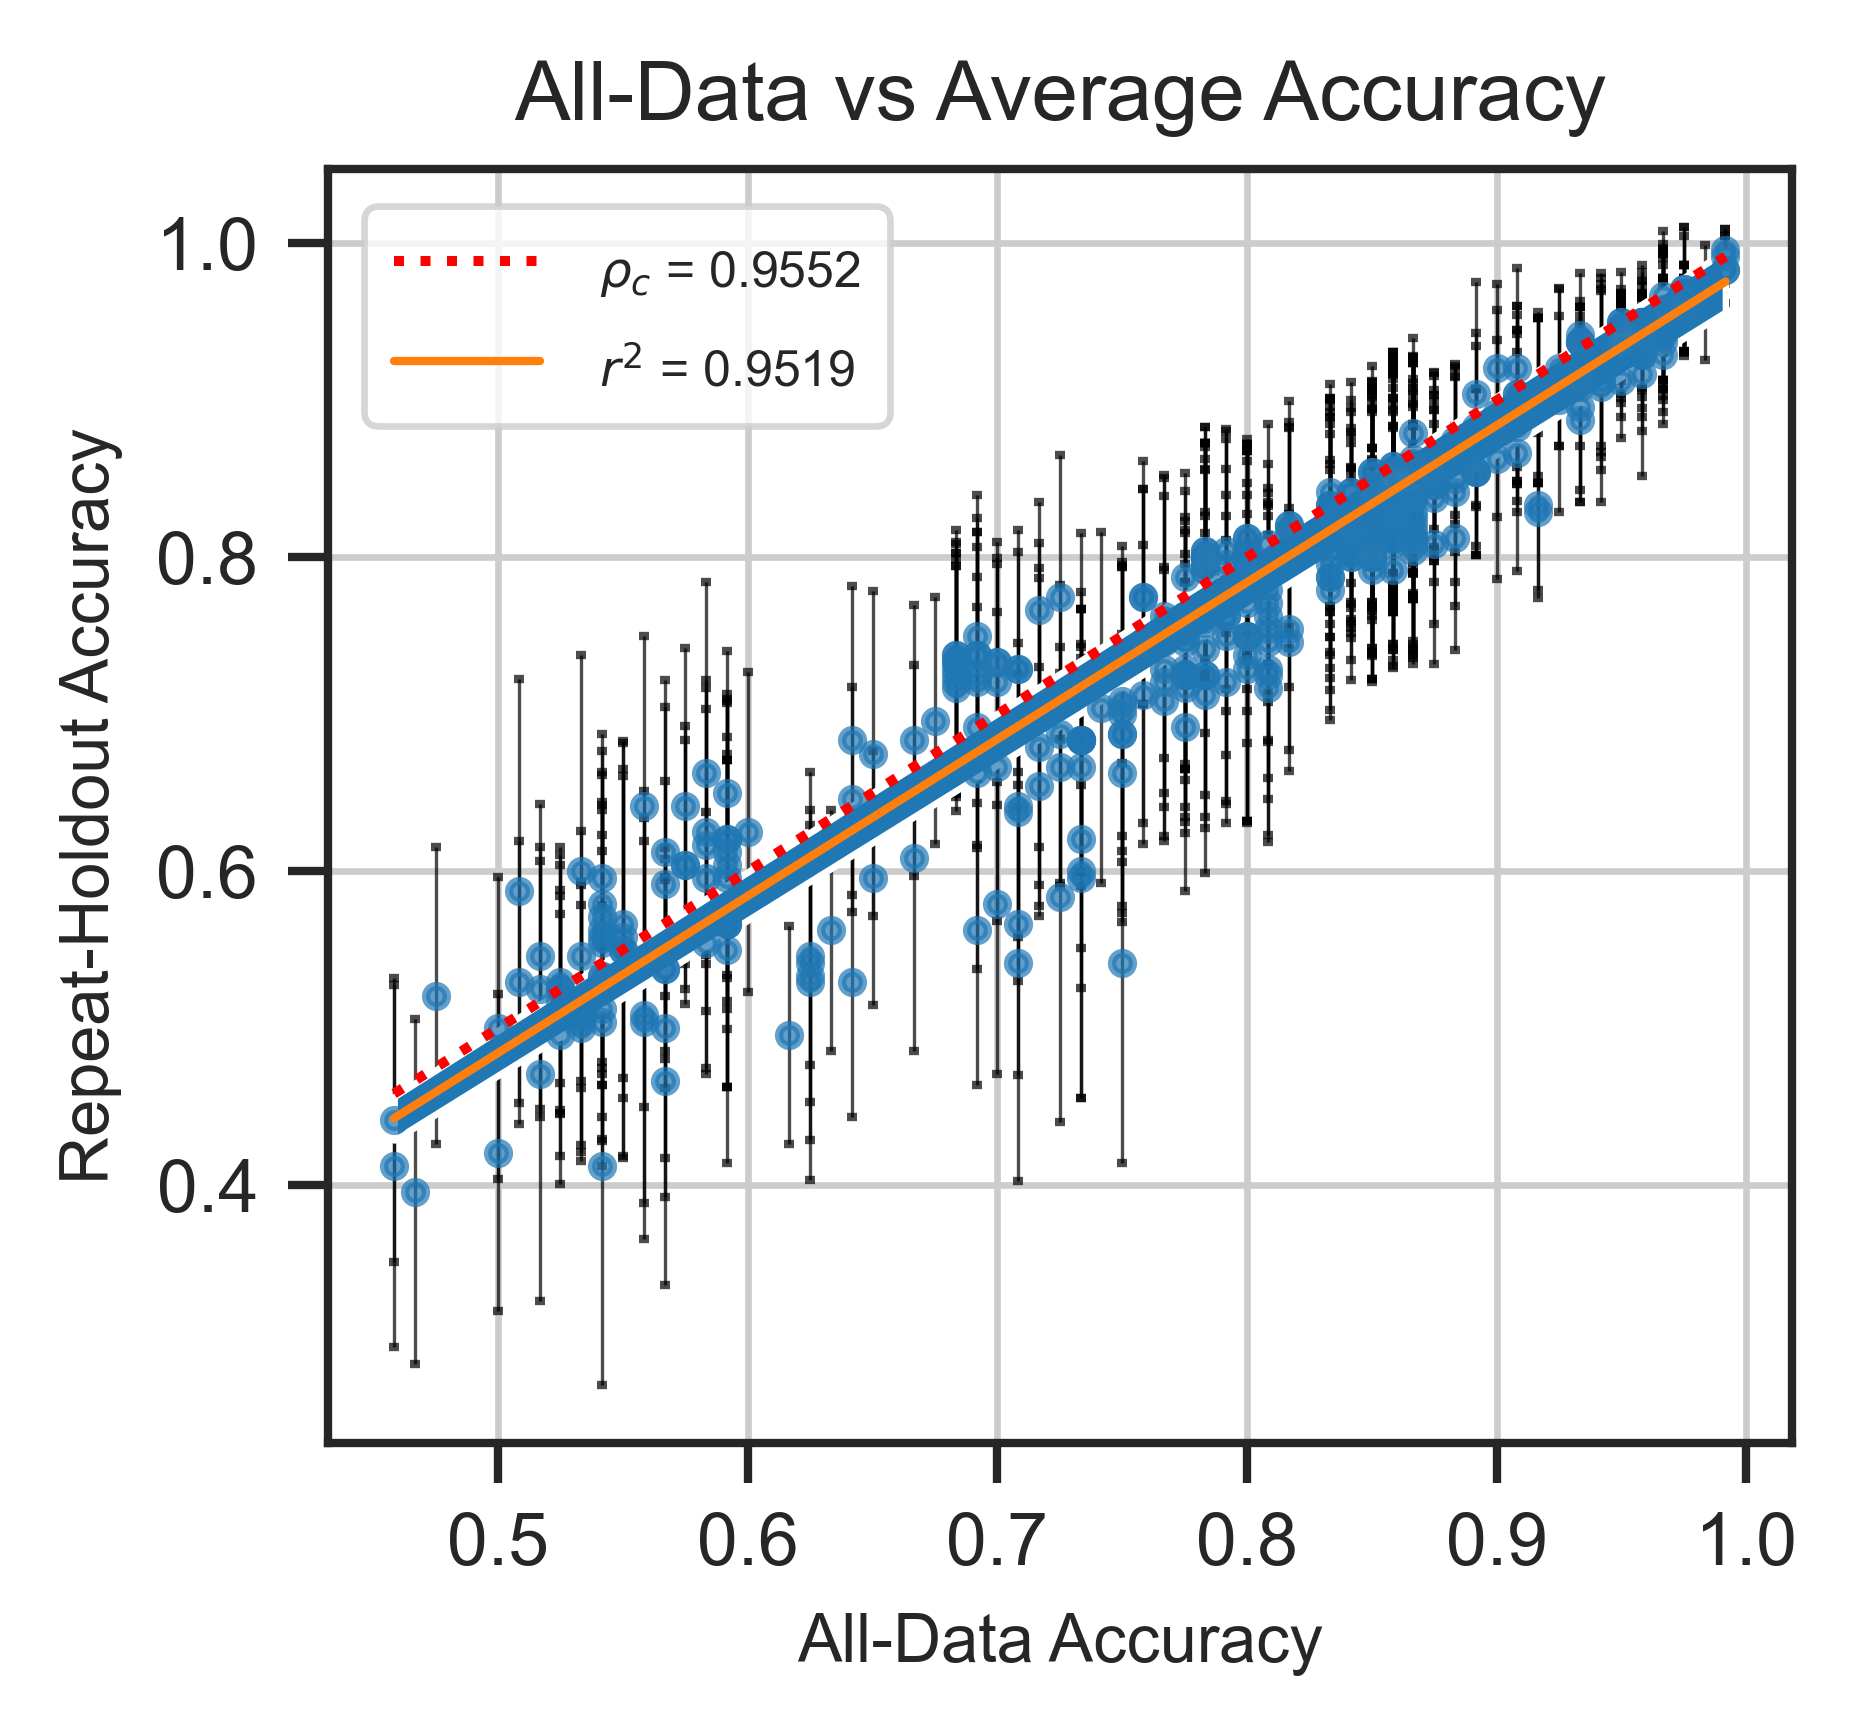

In [82]:
acc_fit = spc.plot_accuracy_stats(lda_acc)

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/final_vs_repeatholdout_accuracy.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/final_vs_repeatholdout_accuracy.png)

In [83]:
print(acc_fit)

{'r^2': 0.9518666633303642, 'ccc': 0.9551591218030906}


## Dataset for Figure 4. D

Supplmentary data are found in the following columns of the complete_results.csv file:  
- x: ```ACC_D```  
- y: ```ACC_mu```  

that can be accessed here via ```complete_df```:

In [84]:
complete_df[['ACC_D', 'ACC_mu']].head()

ACC_D    ACC_mu
spc_id                    
0       0.783333  0.800000
1       0.850000  0.808333
2       0.858333  0.833333
3       0.858333  0.845833
4       0.816667  0.800000

## Figure 4. E

### Mean vs. Coefficient-of-Variation Analysis of Fisher Ratio and Classification Accuracy

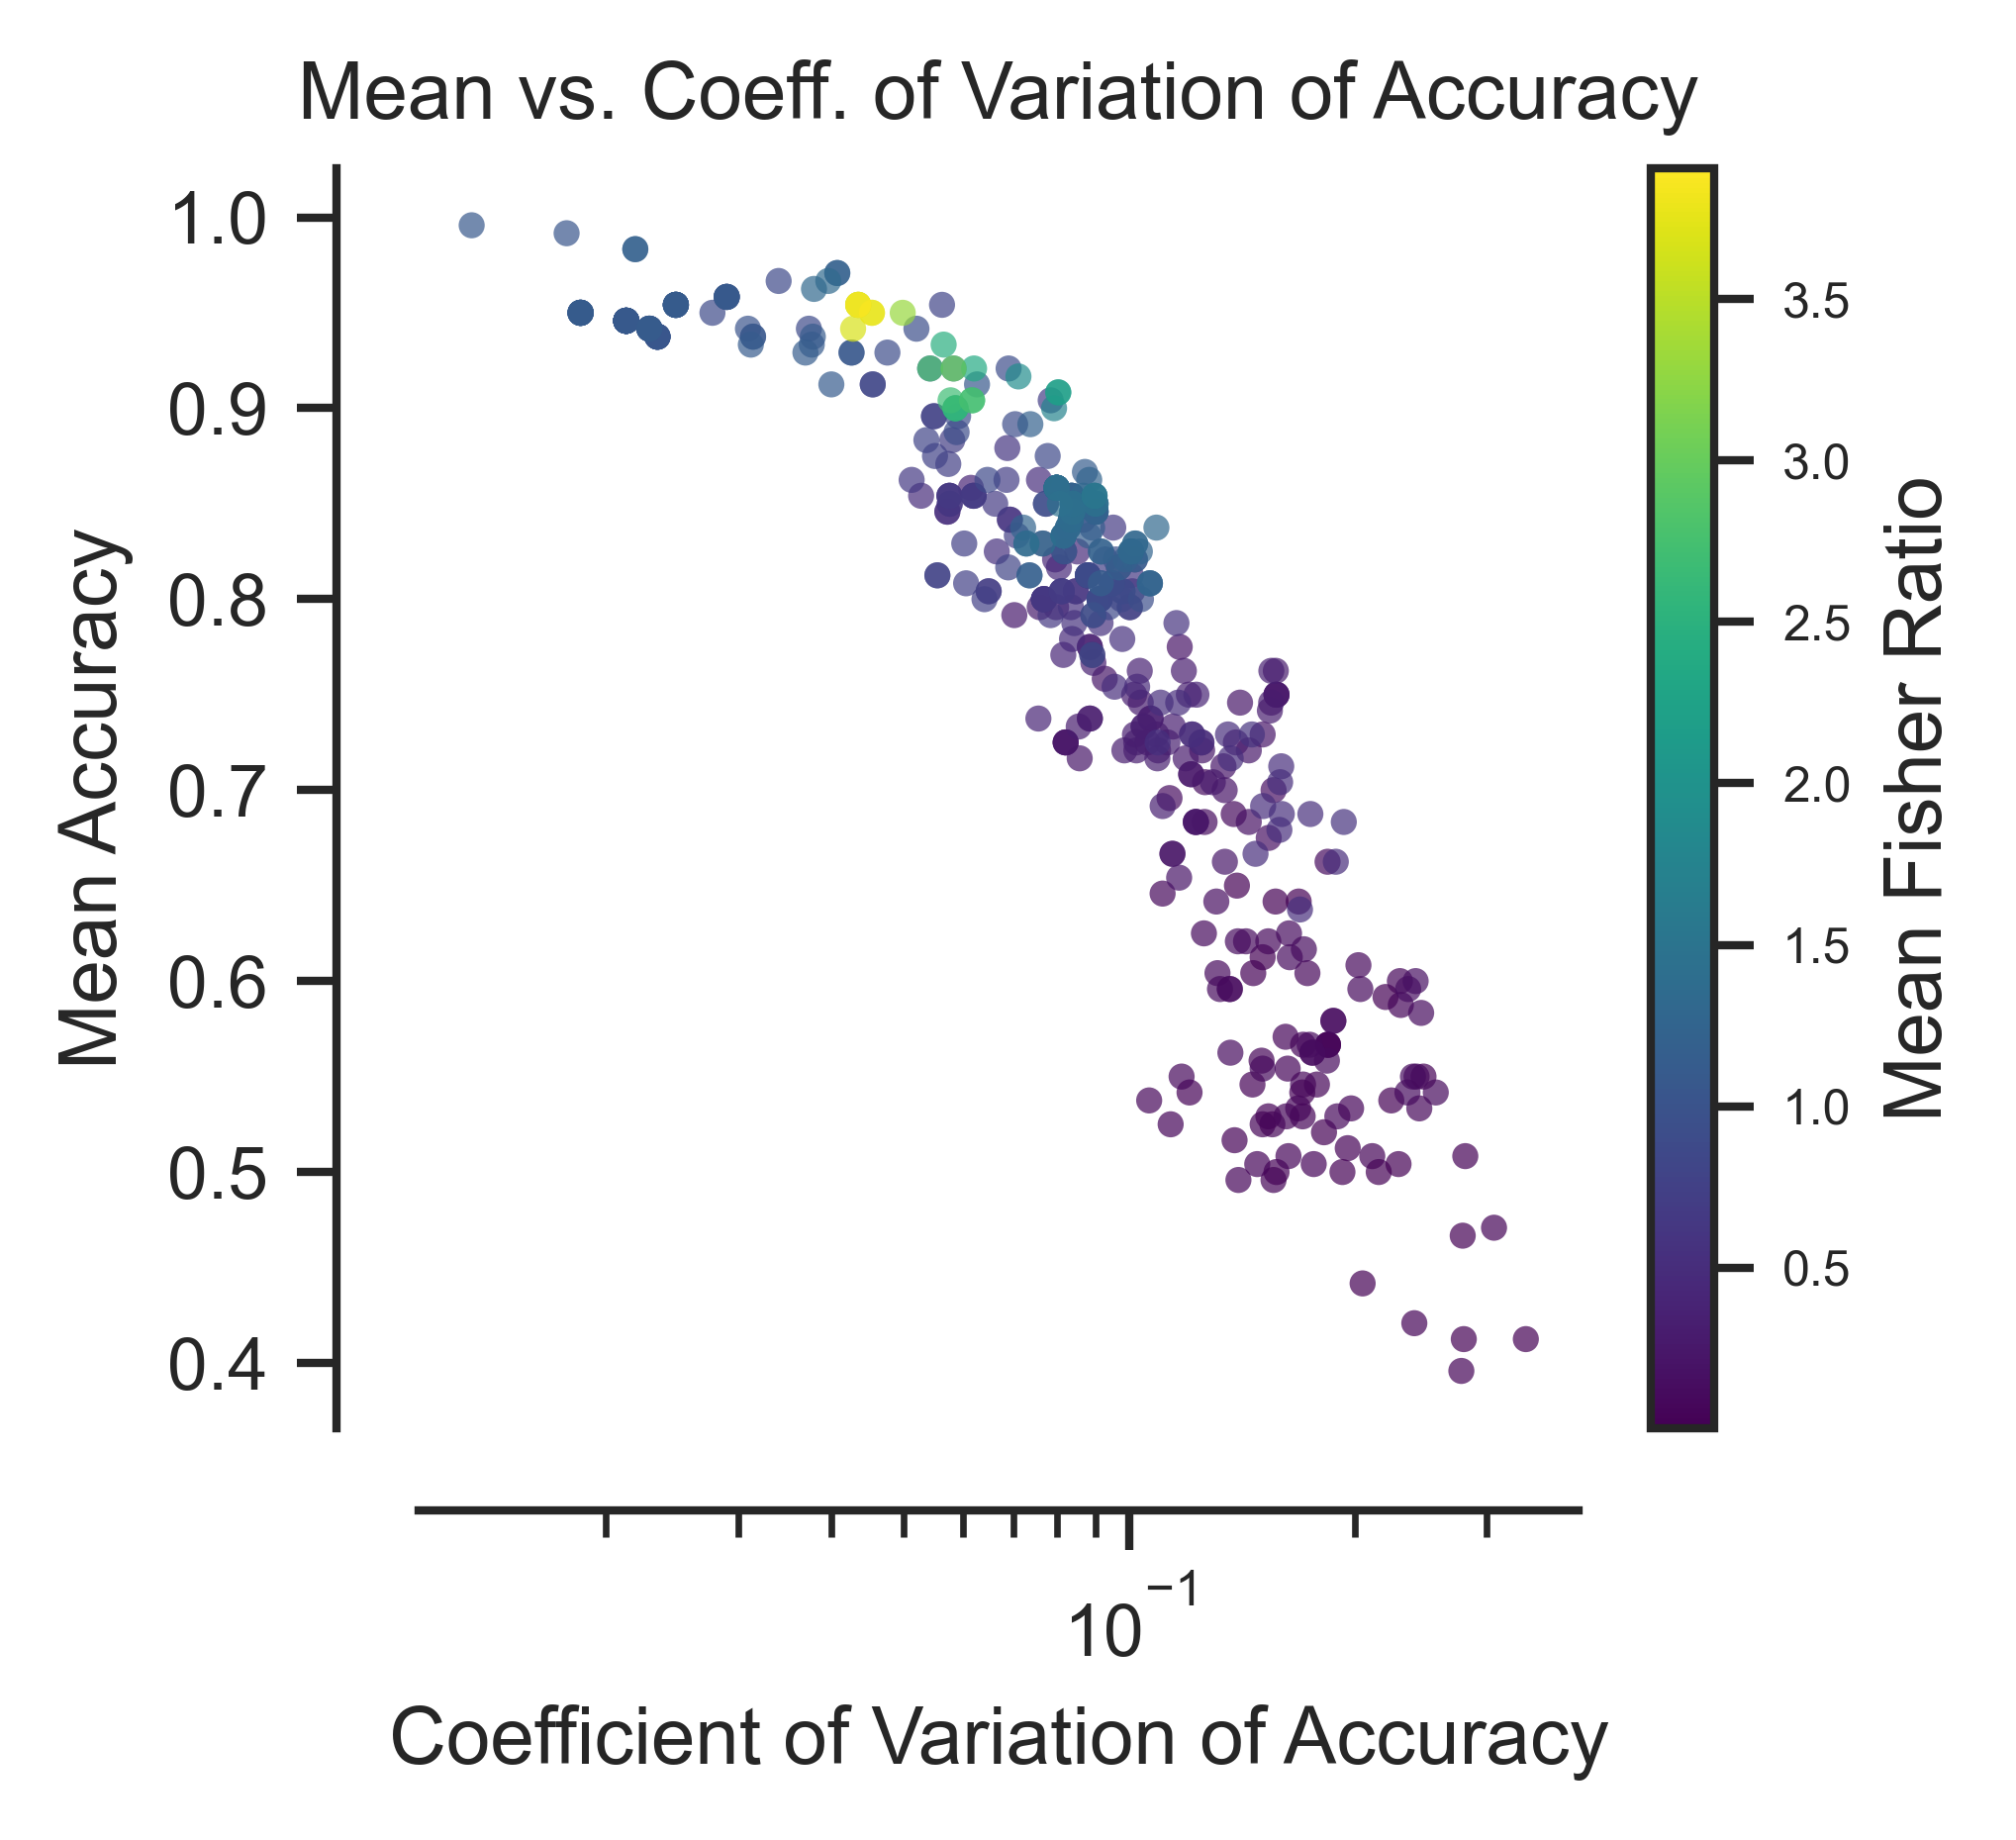

In [85]:
spc.plot_mean_cv('accuracy')

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/mean_cv_accuracy.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/mean_cv_accuracy.png)

## Dataset for Figure 4. E

Supplmentary data are found by accessing the following columns of the complete_results.csv file:  
- x: ```ACC_var```, ```ACC_mu``` (x= $\sqrt{}$```ACC_var```/```ACC_mu```)  
- y: ```ACC_mu``` 
- hue: ```FR_mu``` 

that can be accessed here via ```complete_df```:

In [86]:
complete_df[['ACC_var', 'ACC_mu', 'FR_mu']].head()

ACC_var    ACC_mu     FR_mu
spc_id                              
0       0.005324  0.800000  0.863968
1       0.007407  0.808333  1.240690
2       0.004630  0.833333  1.338007
3       0.005806  0.845833  1.202308
4       0.006867  0.800000  0.942444

## Figure 4. F

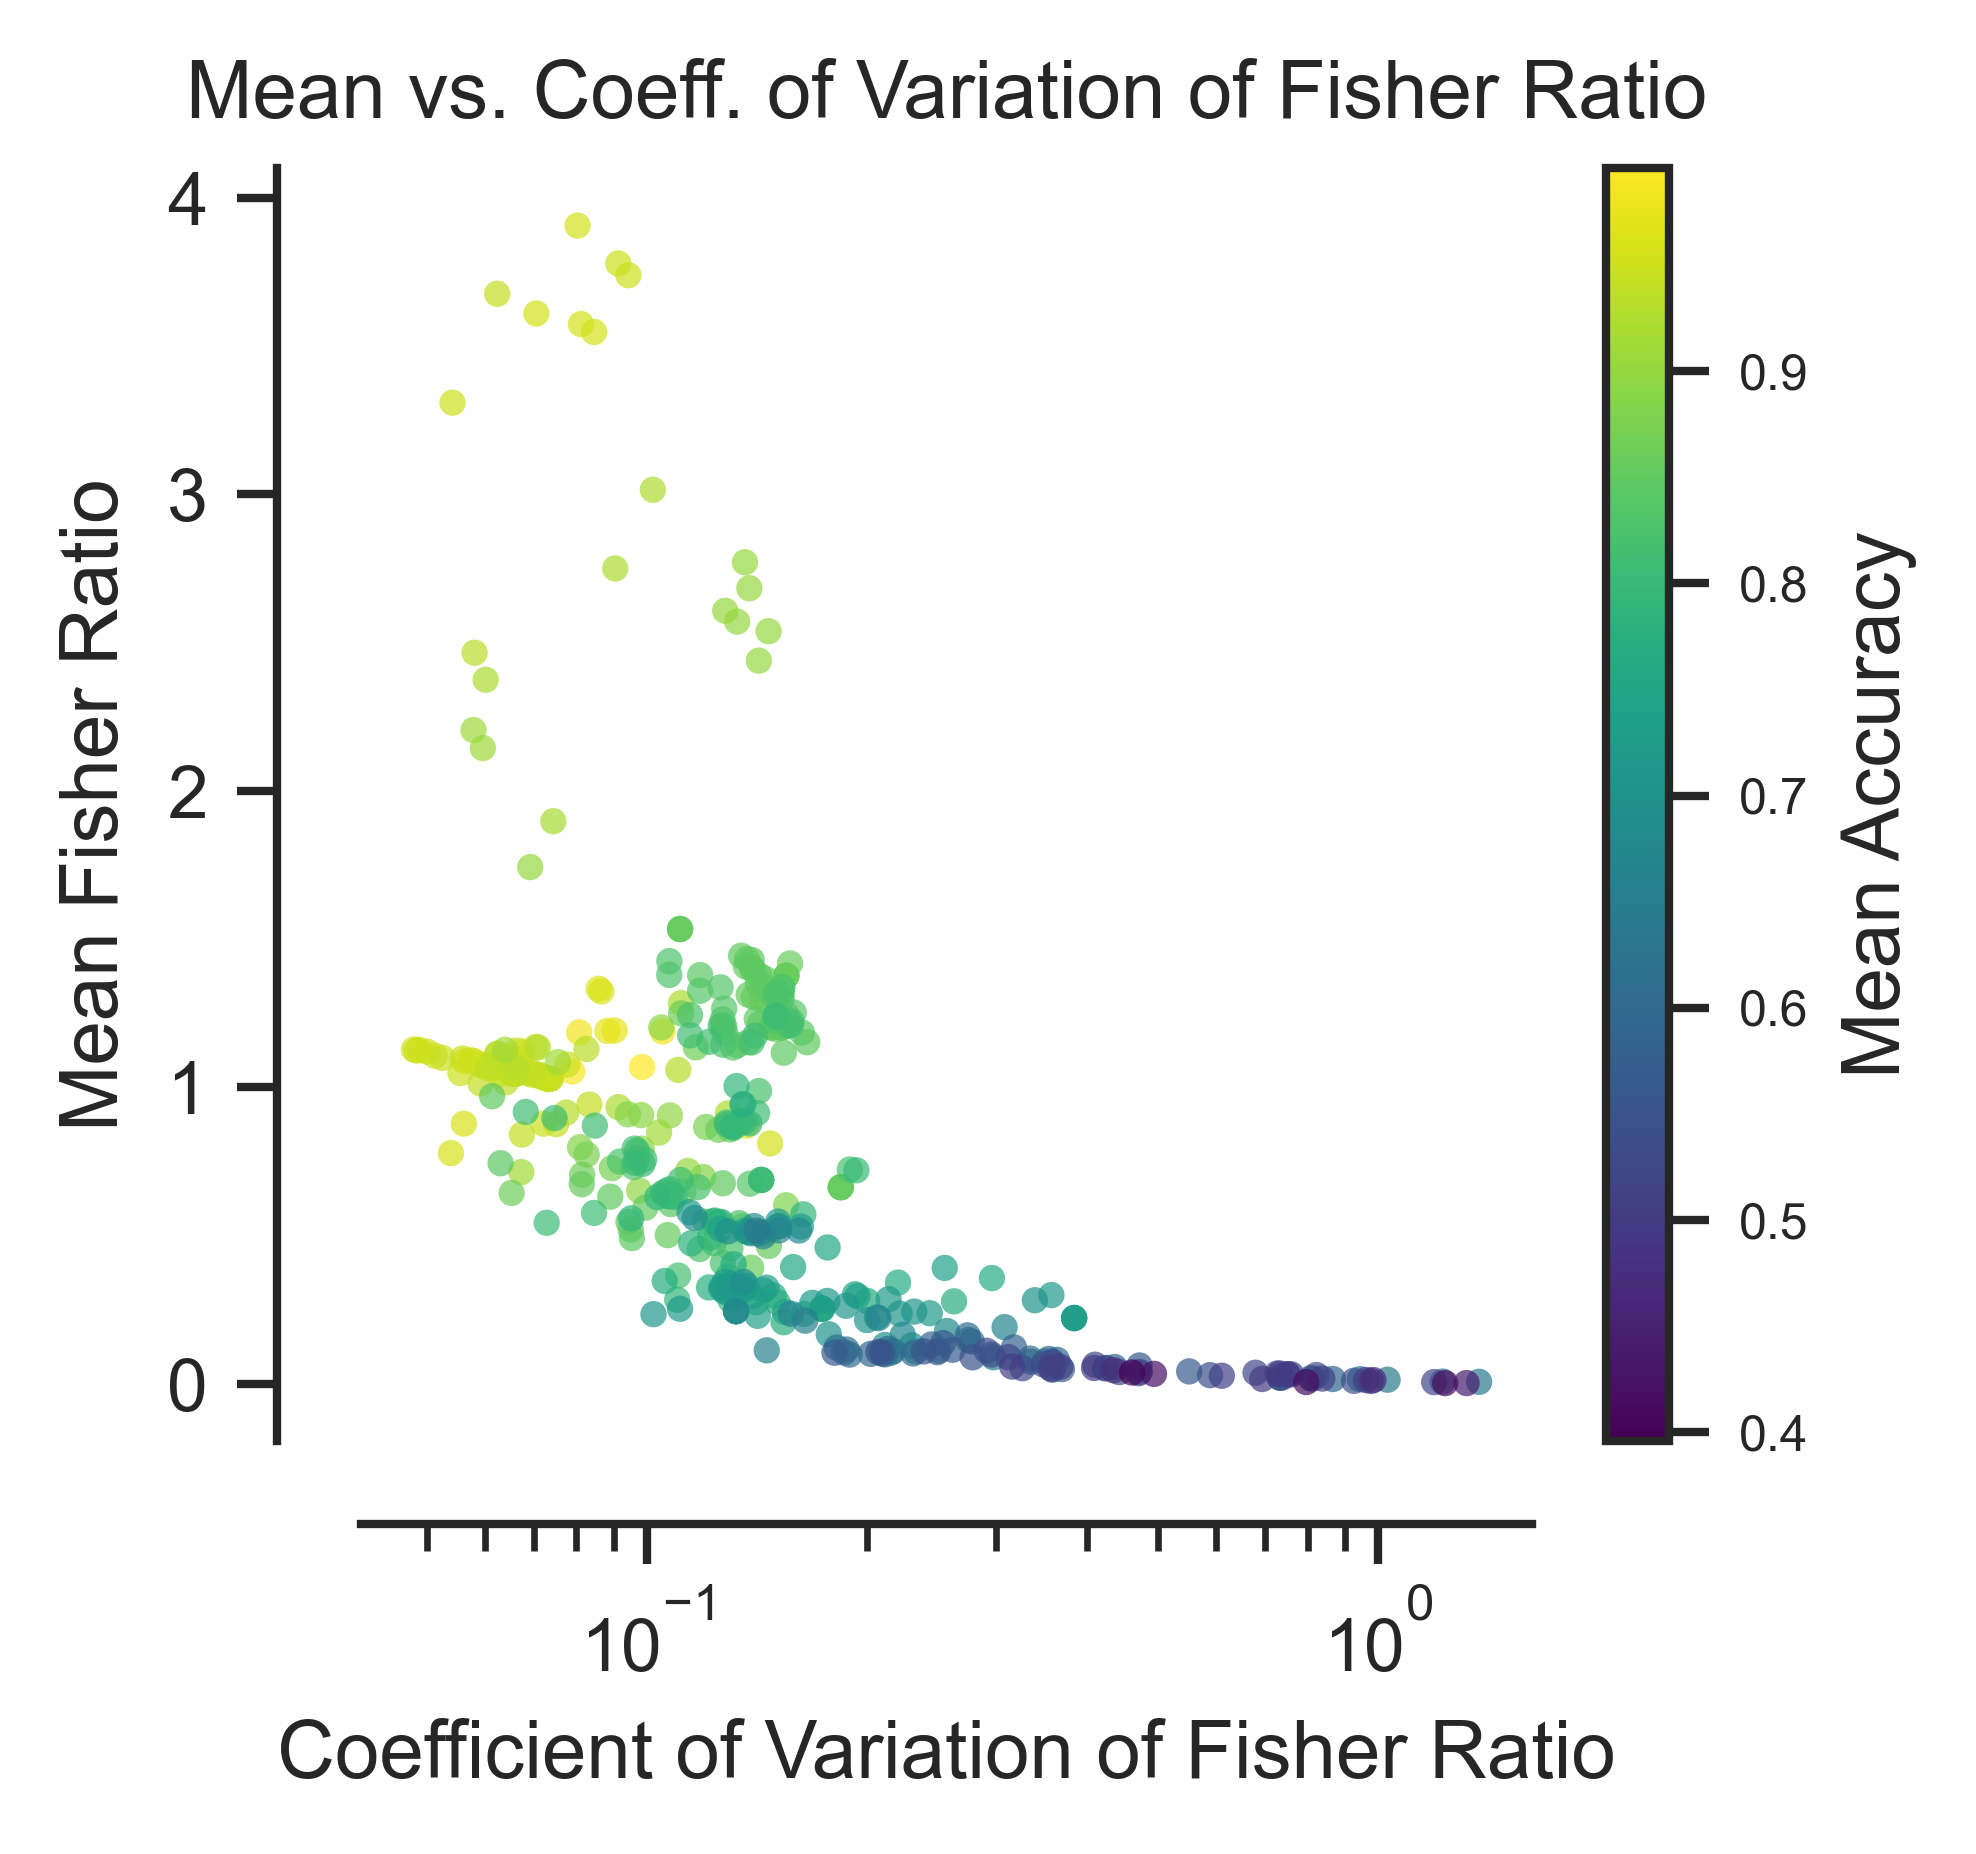

In [87]:
spc.plot_mean_cv('fisher_ratio')

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/mean_cv_fisher_ratio.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/analysis/mean_cv_fisher_ratio.png)

## Dataset for Figure 4. F

Supplmentary data are found by accessing the following columns of the complete_results.csv file:  
- x: ```FR_var```, ```FR_mu``` (x= $\sqrt{}$```FR_var```/```FR_mu```)  
- y: ```FR_mu``` 
- hue: ```ACC_mu``` 

that can be accessed here via ```complete_df```:

In [88]:
complete_df[['FR_var', 'FR_mu', 'ACC_mu']].head()

FR_var     FR_mu    ACC_mu
spc_id                              
0       0.012851  0.863968  0.800000
1       0.034658  1.240690  0.808333
2       0.041903  1.338007  0.833333
3       0.033705  1.202308  0.845833
4       0.016292  0.942444  0.800000

# Discussion

## On the Recommended Filter Subsets 

Here we define SPCs in the top percentile (i.e. percentile score of > 99%) as 'high performing', and we define the recommended filter subset as the SPC with the minimum number of unique filters in this set.

For the ranking systems of All-Data Fisher Ratio and Mean Accuracy, we access these recommendations with the following code:

## For the All-Data Fisher Ratio:

In [89]:
hp_spcs = top_fr_d[top_fr_d['pct_lda_score'] > 99]
recc_spc_fr_d = hp_spcs[hp_spcs['n_uniq_fltrs'] == hp_spcs['n_uniq_fltrs'].min()]
recc_spc_fr_d

lda_score  n_uniq_fltrs       uniq_fltrs  sp_0            sp_1  \
spc_id                                                                   
54       3.856954             3  (RED, PAN, NIR)  R675  BD_675_836_937   

        pct_lda_score     scope  
spc_id                           
54              100.0  $FR_{D}$

## Figure 5. A & C

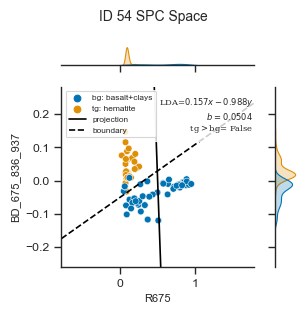

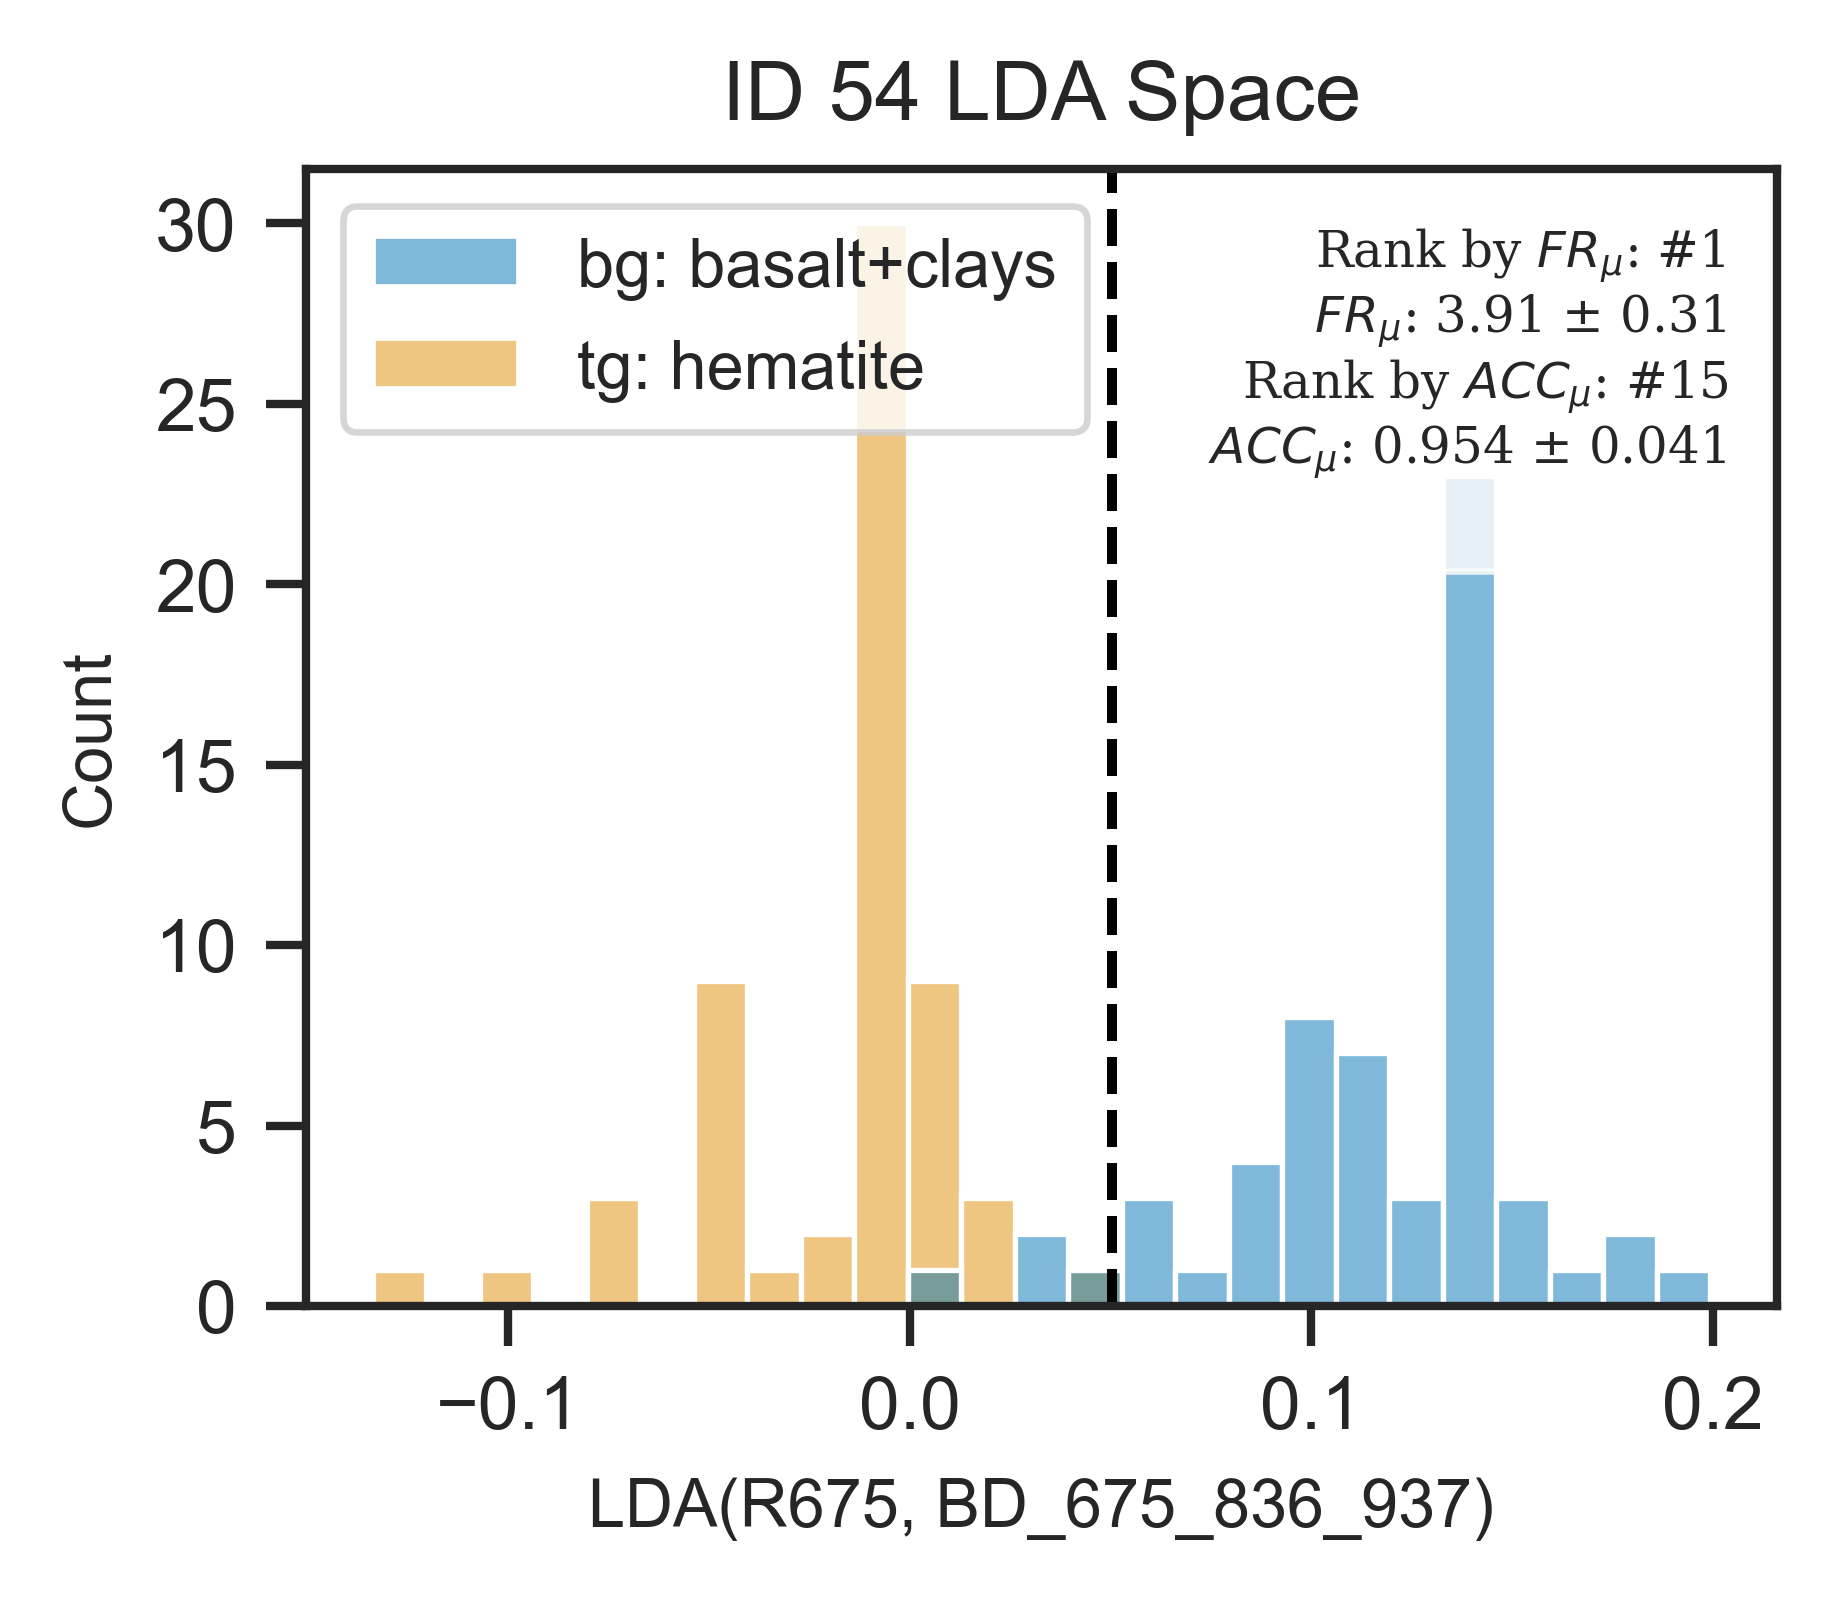

In [90]:
spc.plot_sp_combo(spc_id=recc_spc_fr_d.index[0], spectral_parameters=sps, metric='lda_score', scope='all-data')
spc.plot_spc_lda(spc_id=recc_spc_fr_d.index[0], spectral_parameters=sps, metric='lda_score', scope='all-data')

### Figure 5. A File Link:

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_2_rank_lda_score-all-data_57_R440_v_R_440_500.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_2_rank_lda_score-all-data_57_R440_v_R_440_500.png)

### Figure 5. C File Link:

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_2_rank_lda_score-all-data_57_R440_v_R_440_500_LDA.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_2_rank_lda_score-all-data_57_R440_v_R_440_500_LDA.png)

## Dataset 16

Data for Figure 5. A

Original File link:
[../projects/stabbinsstabbins2024_exmpc_hematite_paper_data_products2024_ess_paper_walkthrough/spc_classifier/spc_plots/nuc_2_rank_lda_score-all-data_57_R440_v_R_440_500_data.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_2_rank_lda_score-all-data_57_R440_v_R_440_500_data.csv)

## Dataset 17

Data for Figure 5. C

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_2_rank_lda_score-mean_52_R440_v_R_440_500_LDA_data.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_2_rank_lda_score-mean_52_R440_v_R_440_500_LDA_data.csv)

## For the Mean Accuracy:

In [91]:
# # recommended by ACC_mu
hp_spcs = top_acc_mu[top_acc_mu['pct_lda_acc_1'] > 99]
recc_spc_acc_mu = hp_spcs[hp_spcs['n_uniq_fltrs'] == hp_spcs['n_uniq_fltrs'].min()]
recc_spc_acc_mu

lda_acc_1  n_uniq_fltrs       uniq_fltrs       sp_0       sp_1  \
spc_id                                                                   
349      0.995833             3  (RED, PAN, NIR)  R_937_836  S_675_836   

        pct_lda_acc_1        scope  
spc_id                              
349             100.0  $ACC_{\mu}$

## Figure 5. B & D

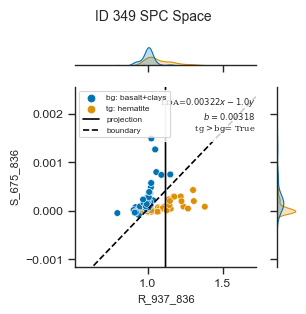

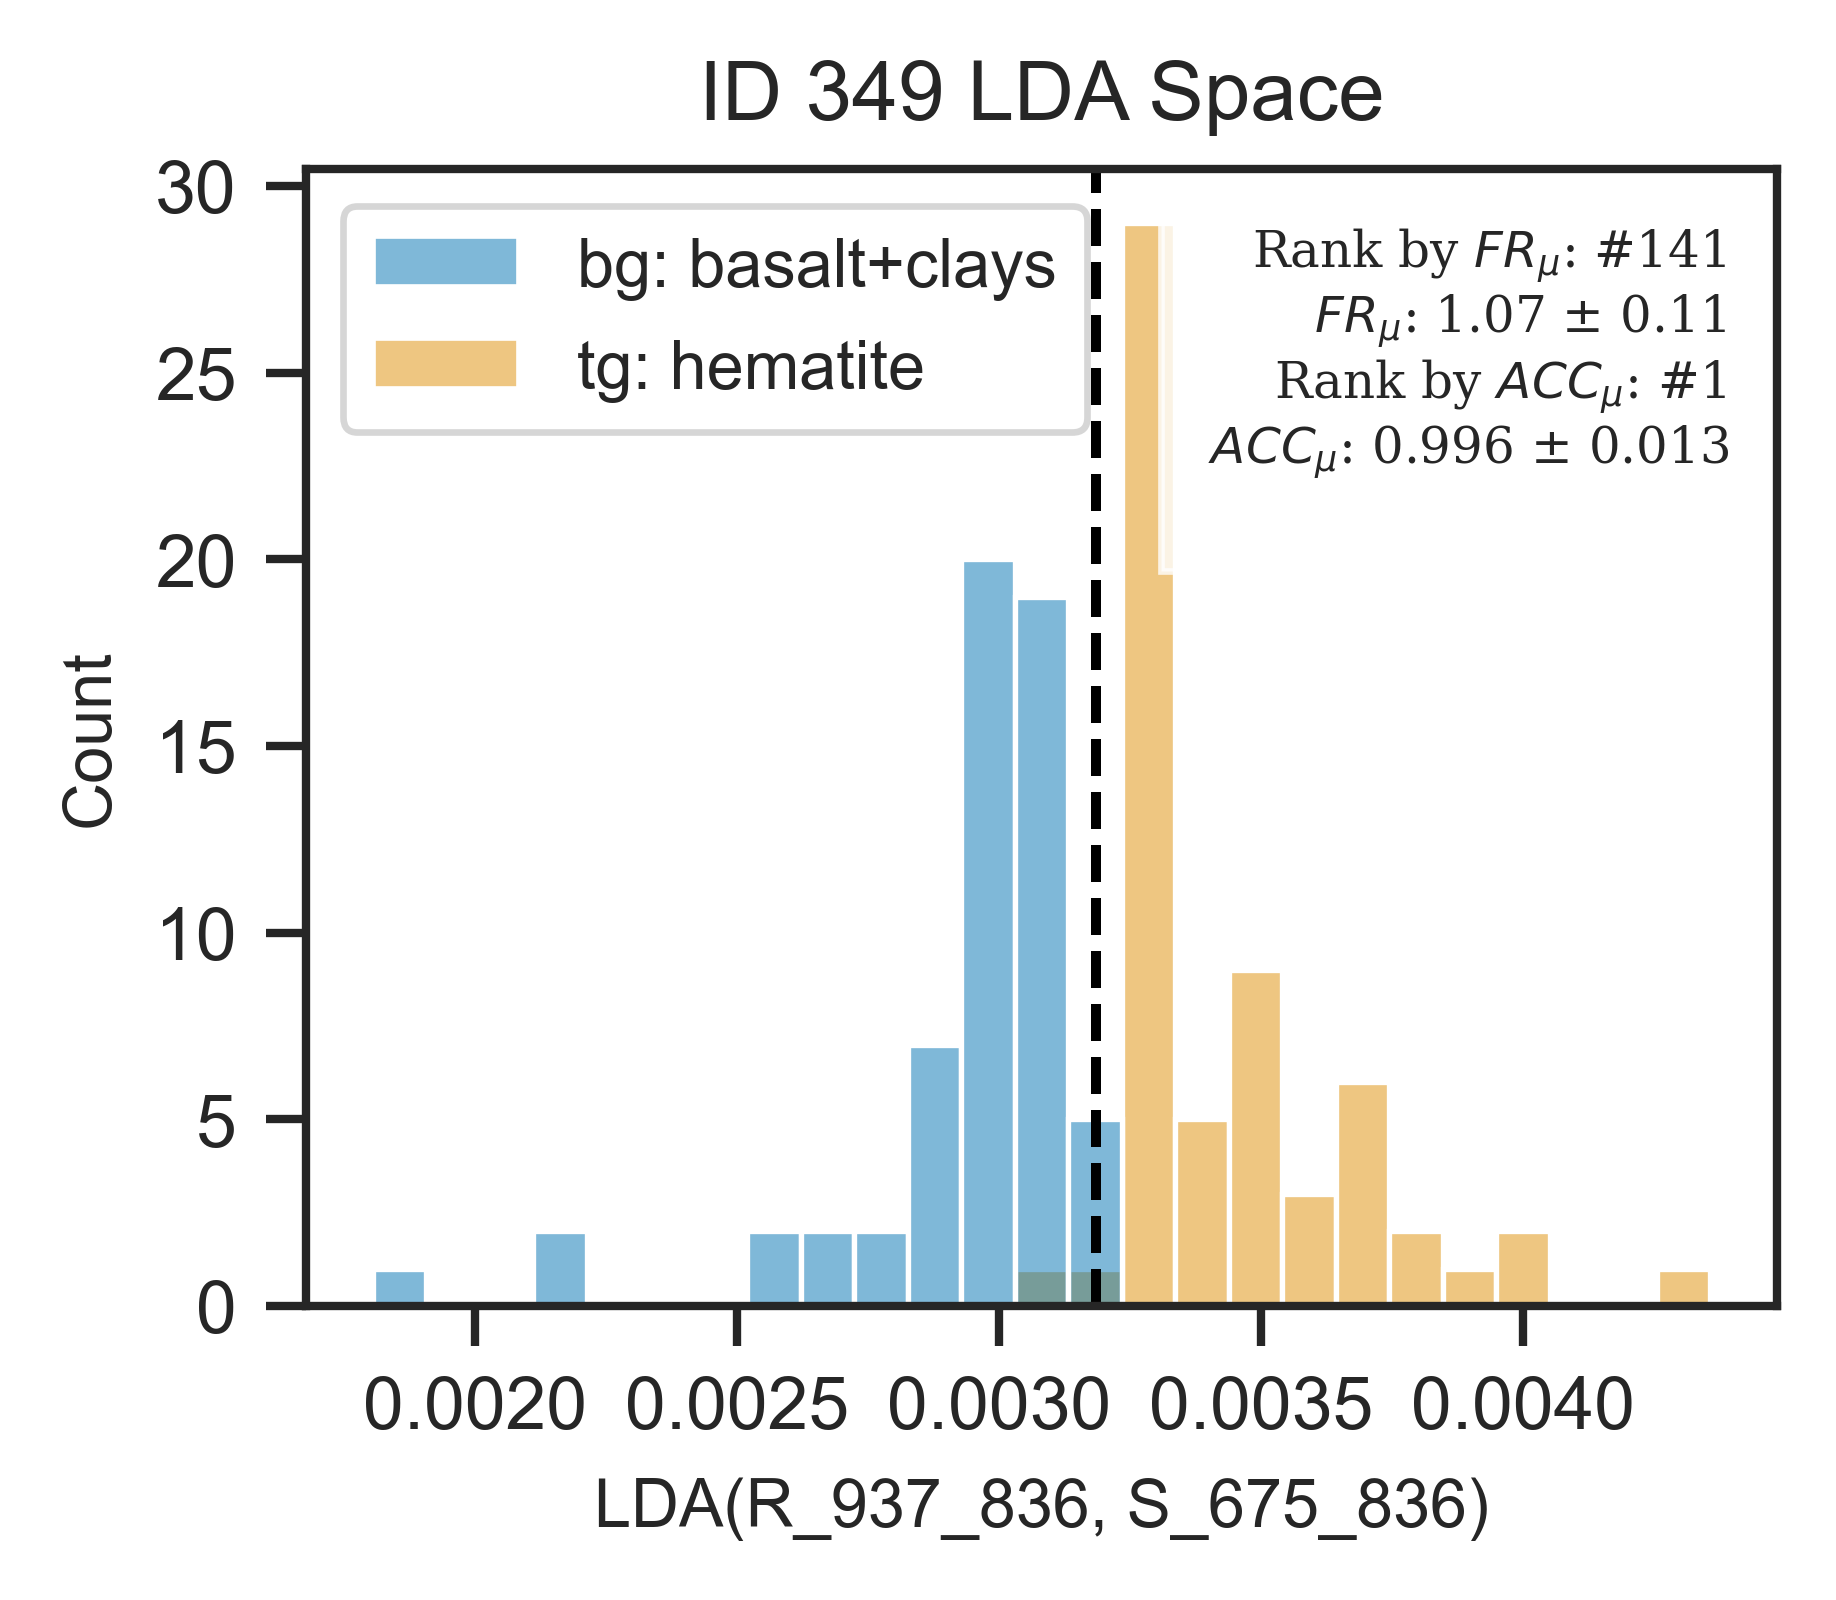

In [92]:
spc.plot_sp_combo(spc_id=recc_spc_acc_mu.index[0], spectral_parameters=sps, metric='lda_acc_1', scope='mean')
spc.plot_spc_lda(spc_id=recc_spc_acc_mu.index[0], spectral_parameters=sps, metric='lda_acc_1', scope='mean')

### Figure 5. B File Link:

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_3_rank_lda_acc_1-mean_2_R_440_500_v_R_440_530.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_3_rank_lda_acc_1-mean_2_R_440_500_v_R_440_530.png)

### Figure 5. D File Link:

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_lda_acc_1-mean_2_R_440_500_v_R_440_530_LDA.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_lda_acc_1-mean_2_R_440_500_v_R_440_530_LDA.png)

## Dataset 18

Data for Figure 5. B

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_3_rank_lda_acc_1-mean_2_R_440_500_v_R_440_530_data.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/spc_plots/nuc_3_rank_lda_acc_1-mean_2_R_440_500_v_R_440_530_data.csv)

## Dataset 19

Data for Figure 5. D

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_lda_acc_1-mean_2_R_440_500_v_R_440_530_LDA_data.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_lda_acc_1-mean_2_R_440_500_v_R_440_530_LDA_data.csv)

## Performance of hematite indicative spectral parameters of the literature

Fraeman et al 2019 used 5 spectral parameters for searching for hematite, that translate to the following 4 PanCam spectral parameters:

- BD_440_530_670 (after Wellington et al 2017)
- BD_740_840_1000 (after Bell et al 2000)
- BD_500_530_610 (after Johnson et al 2015)
- S_740_840 (after Johnson et al 2015)
(Viviano-Beck BD860_2 CRISM spectral parameter indistinguishable from Mastcam BD867 spectral parameter when translated to PanCam spectral sampling).

Here, we query the performance of these spectral parameters in the database.

In [93]:
BD_440_530_670_id = spc.main_df.loc[(spc.main_df['sp_0'] == 'BD_440_530_670') & (spc.main_df['sp_1'] == 'BD_440_530_670')].index.values[0]
BD_740_840_1000_id = spc.main_df.loc[(spc.main_df['sp_0'] == 'BD_740_840_1000') & (spc.main_df['sp_1'] == 'BD_740_840_1000')].index.values[0]
BD_500_530_610_id = spc.main_df.loc[(spc.main_df['sp_0'] == 'BD_500_530_610') & (spc.main_df['sp_1'] == 'BD_500_530_610')].index.values[0]
S_740_840_id = spc.main_df.loc[(spc.main_df['sp_0'] == 'S_740_840') & (spc.main_df['sp_1'] == 'S_740_840')].index.values[0]

spc.main_df.loc[[BD_740_840_1000_id, S_740_840_id, BD_440_530_670_id, BD_500_530_610_id]]


IndexError: index 0 is out of bounds for axis 0 with size 0

## Figure 6. A

<Figure size 314.961x275.591 with 0 Axes>

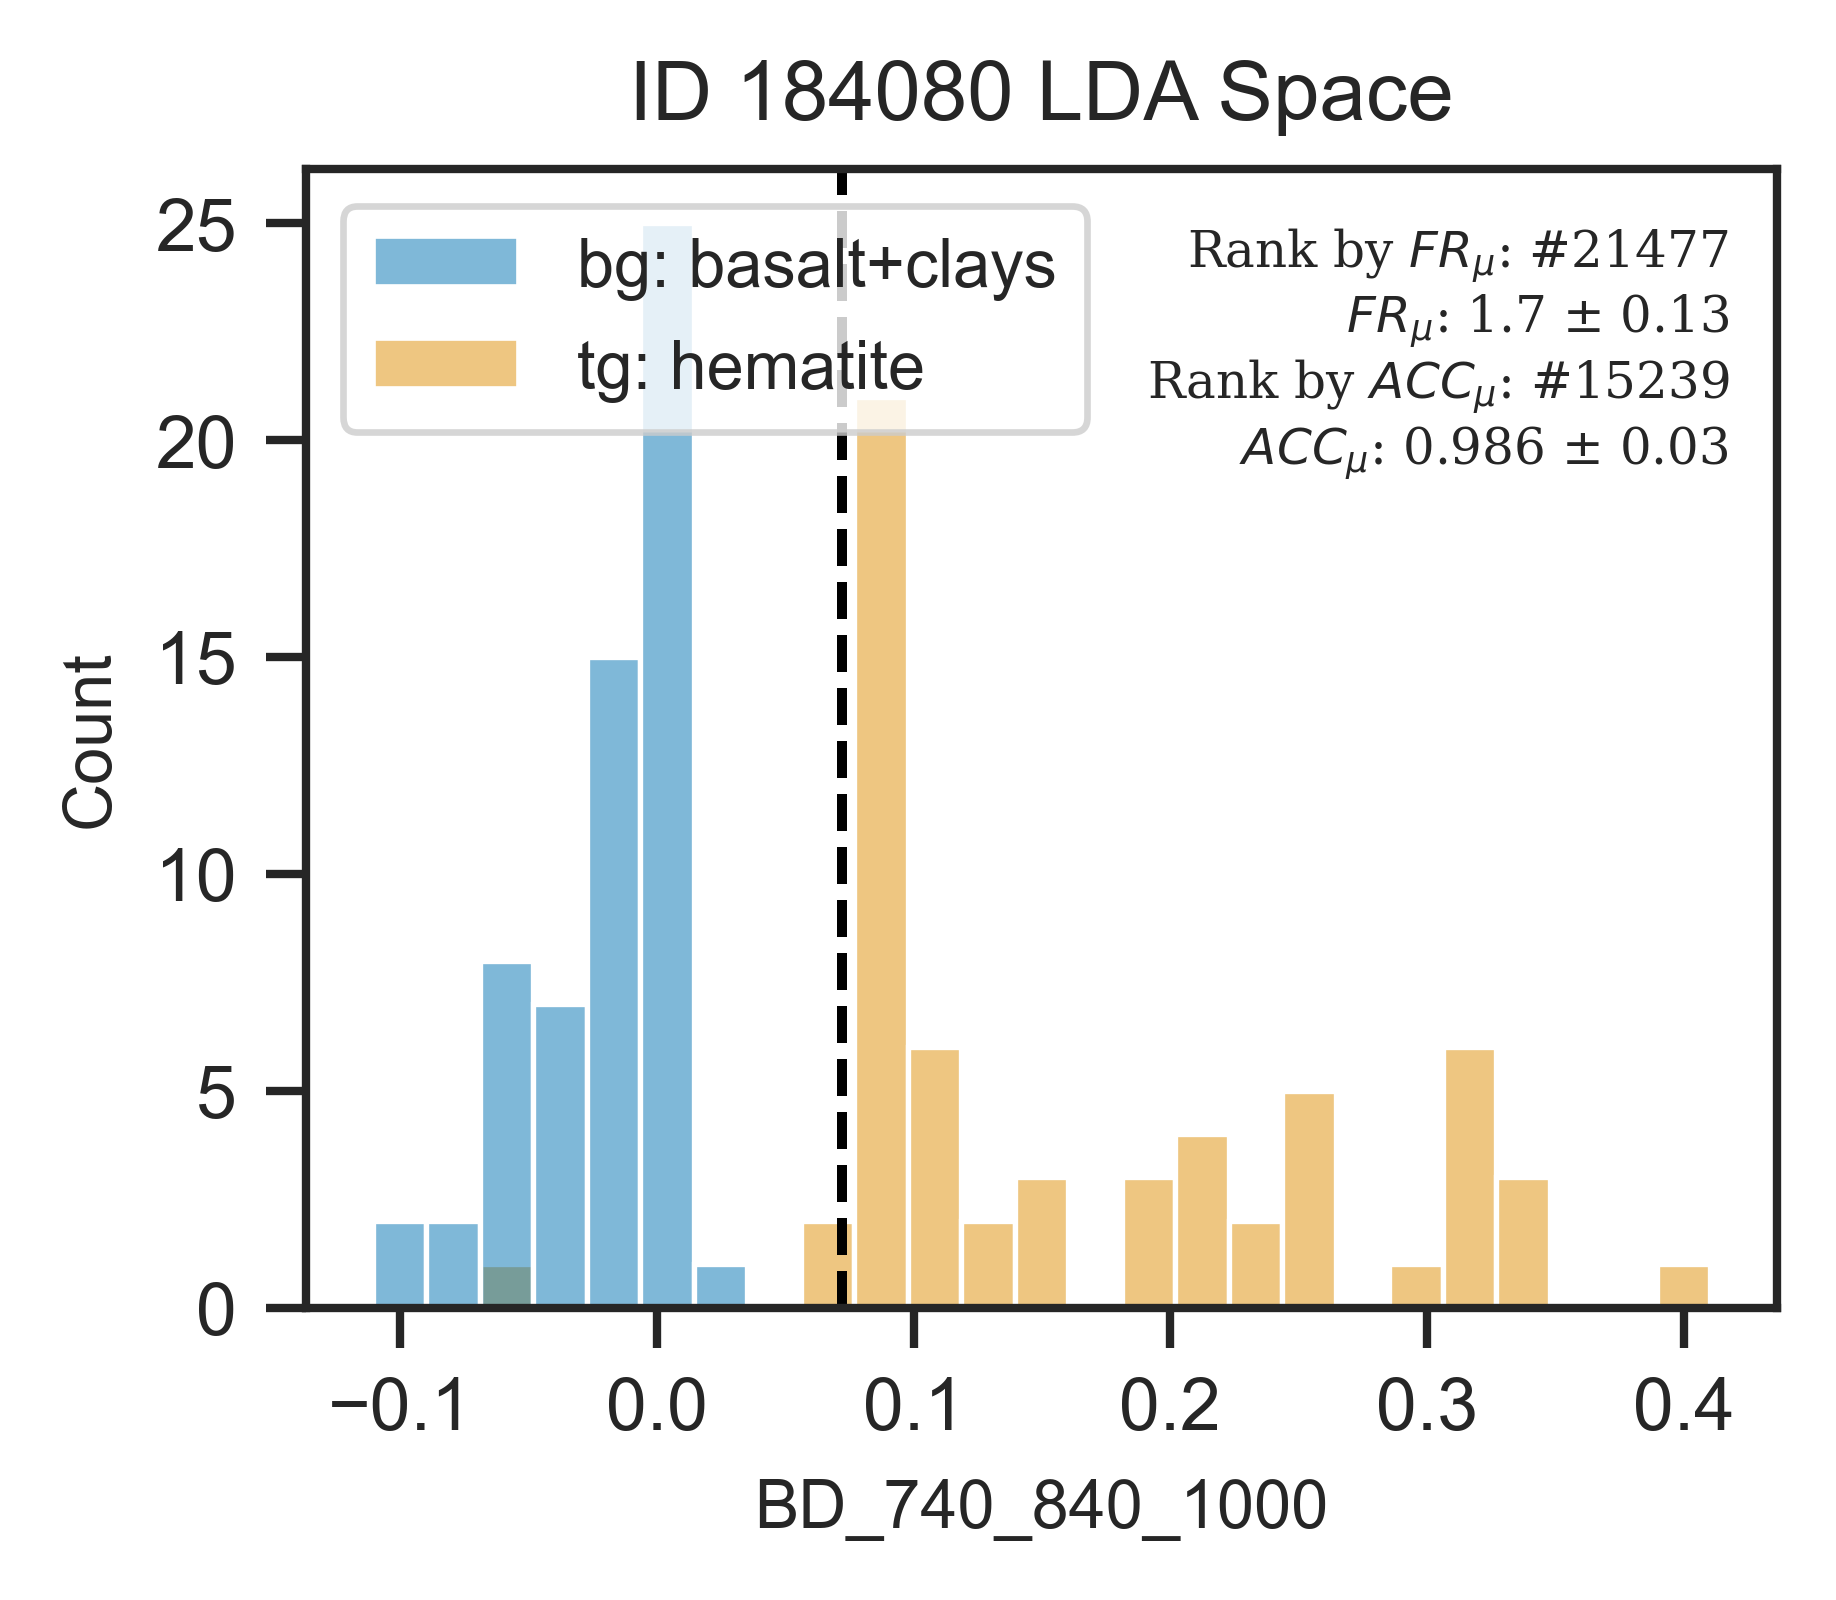

In [ ]:
this_spc_id = spc.main_df.loc[(spc.main_df['sp_0'] == 'BD_740_840_1000') & (spc.main_df['sp_1'] == 'BD_740_840_1000')].index.item()
spc.plot_spc_lda(spc_id=this_spc_id, spectral_parameters=sps)

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_None-None_NA_BD_740_840_1000_LDA.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_None-None_NA_BD_740_840_1000_LDA.png)

## Dataset 20

Data for Figure 6. A

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_None-None_NA_BD_740_840_1000_LDA_data.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_None-None_NA_BD_740_840_1000_LDA_data.csv)

## Figure 6. B

<Figure size 314.961x275.591 with 0 Axes>

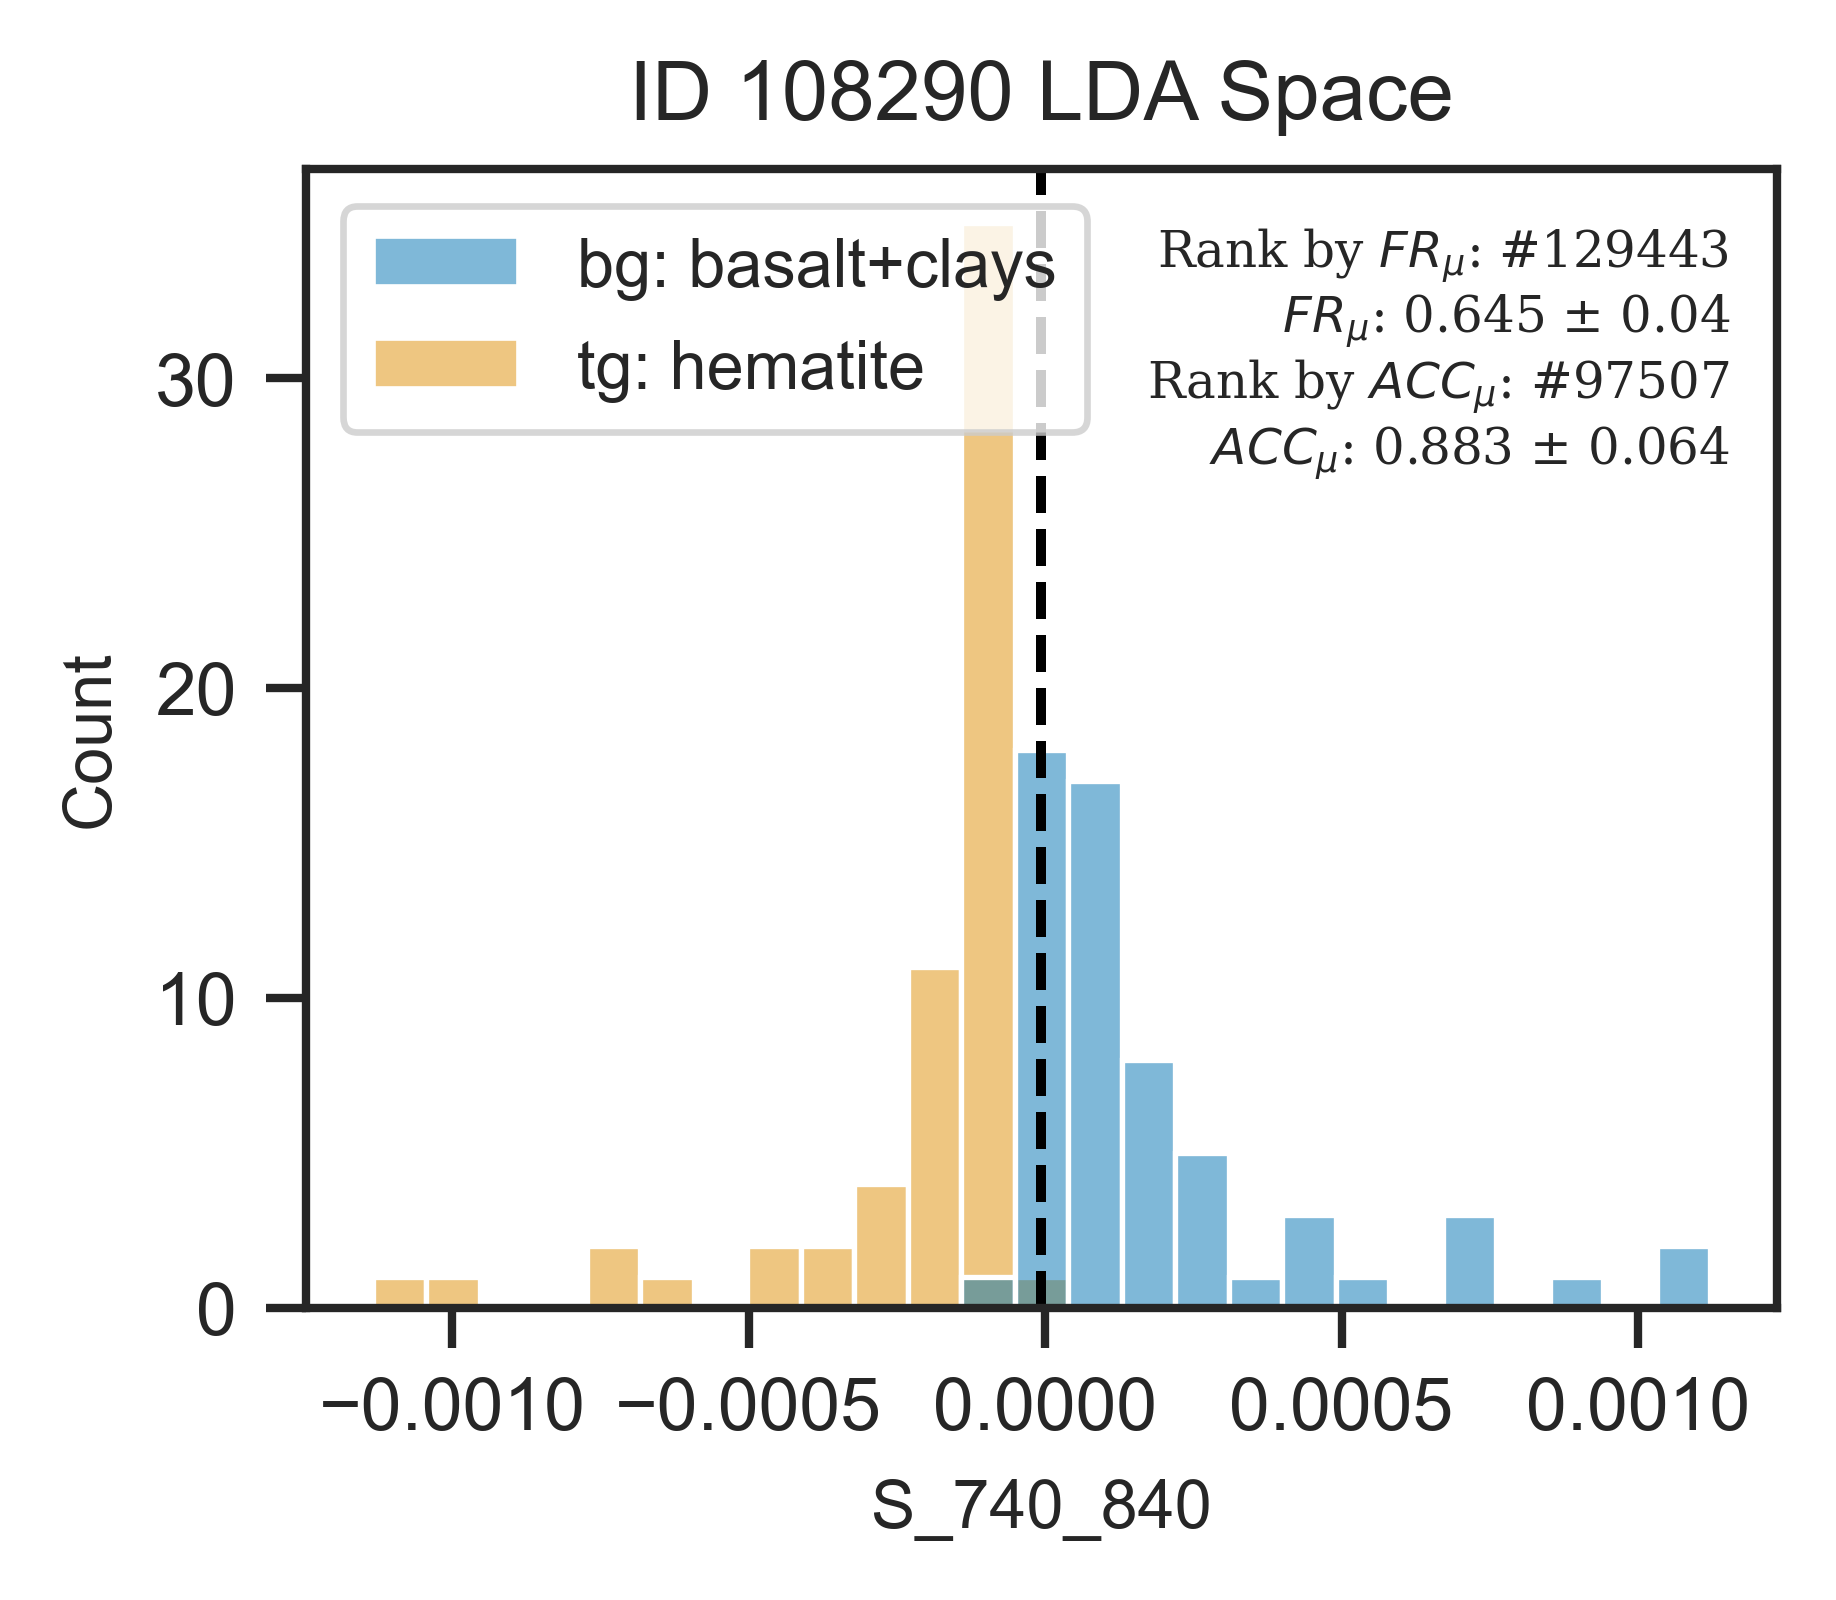

In [ ]:
this_spc_id = spc.main_df.loc[(spc.main_df['sp_0'] == 'S_740_840') & (spc.main_df['sp_1'] == 'S_740_840')].index.item()
spc.plot_spc_lda(spc_id=this_spc_id, spectral_parameters=sps)

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_2_rank_None-None_NA_S_740_840_LDA.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_2_rank_None-None_NA_S_740_840_LDA.png)

## Dataset 21

Data for Figure 6. B

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_2_rank_None-None_NA_S_740_840_LDA_data.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_2_rank_None-None_NA_S_740_840_LDA_data.csv)

## Figure 6. C

<Figure size 314.961x275.591 with 0 Axes>

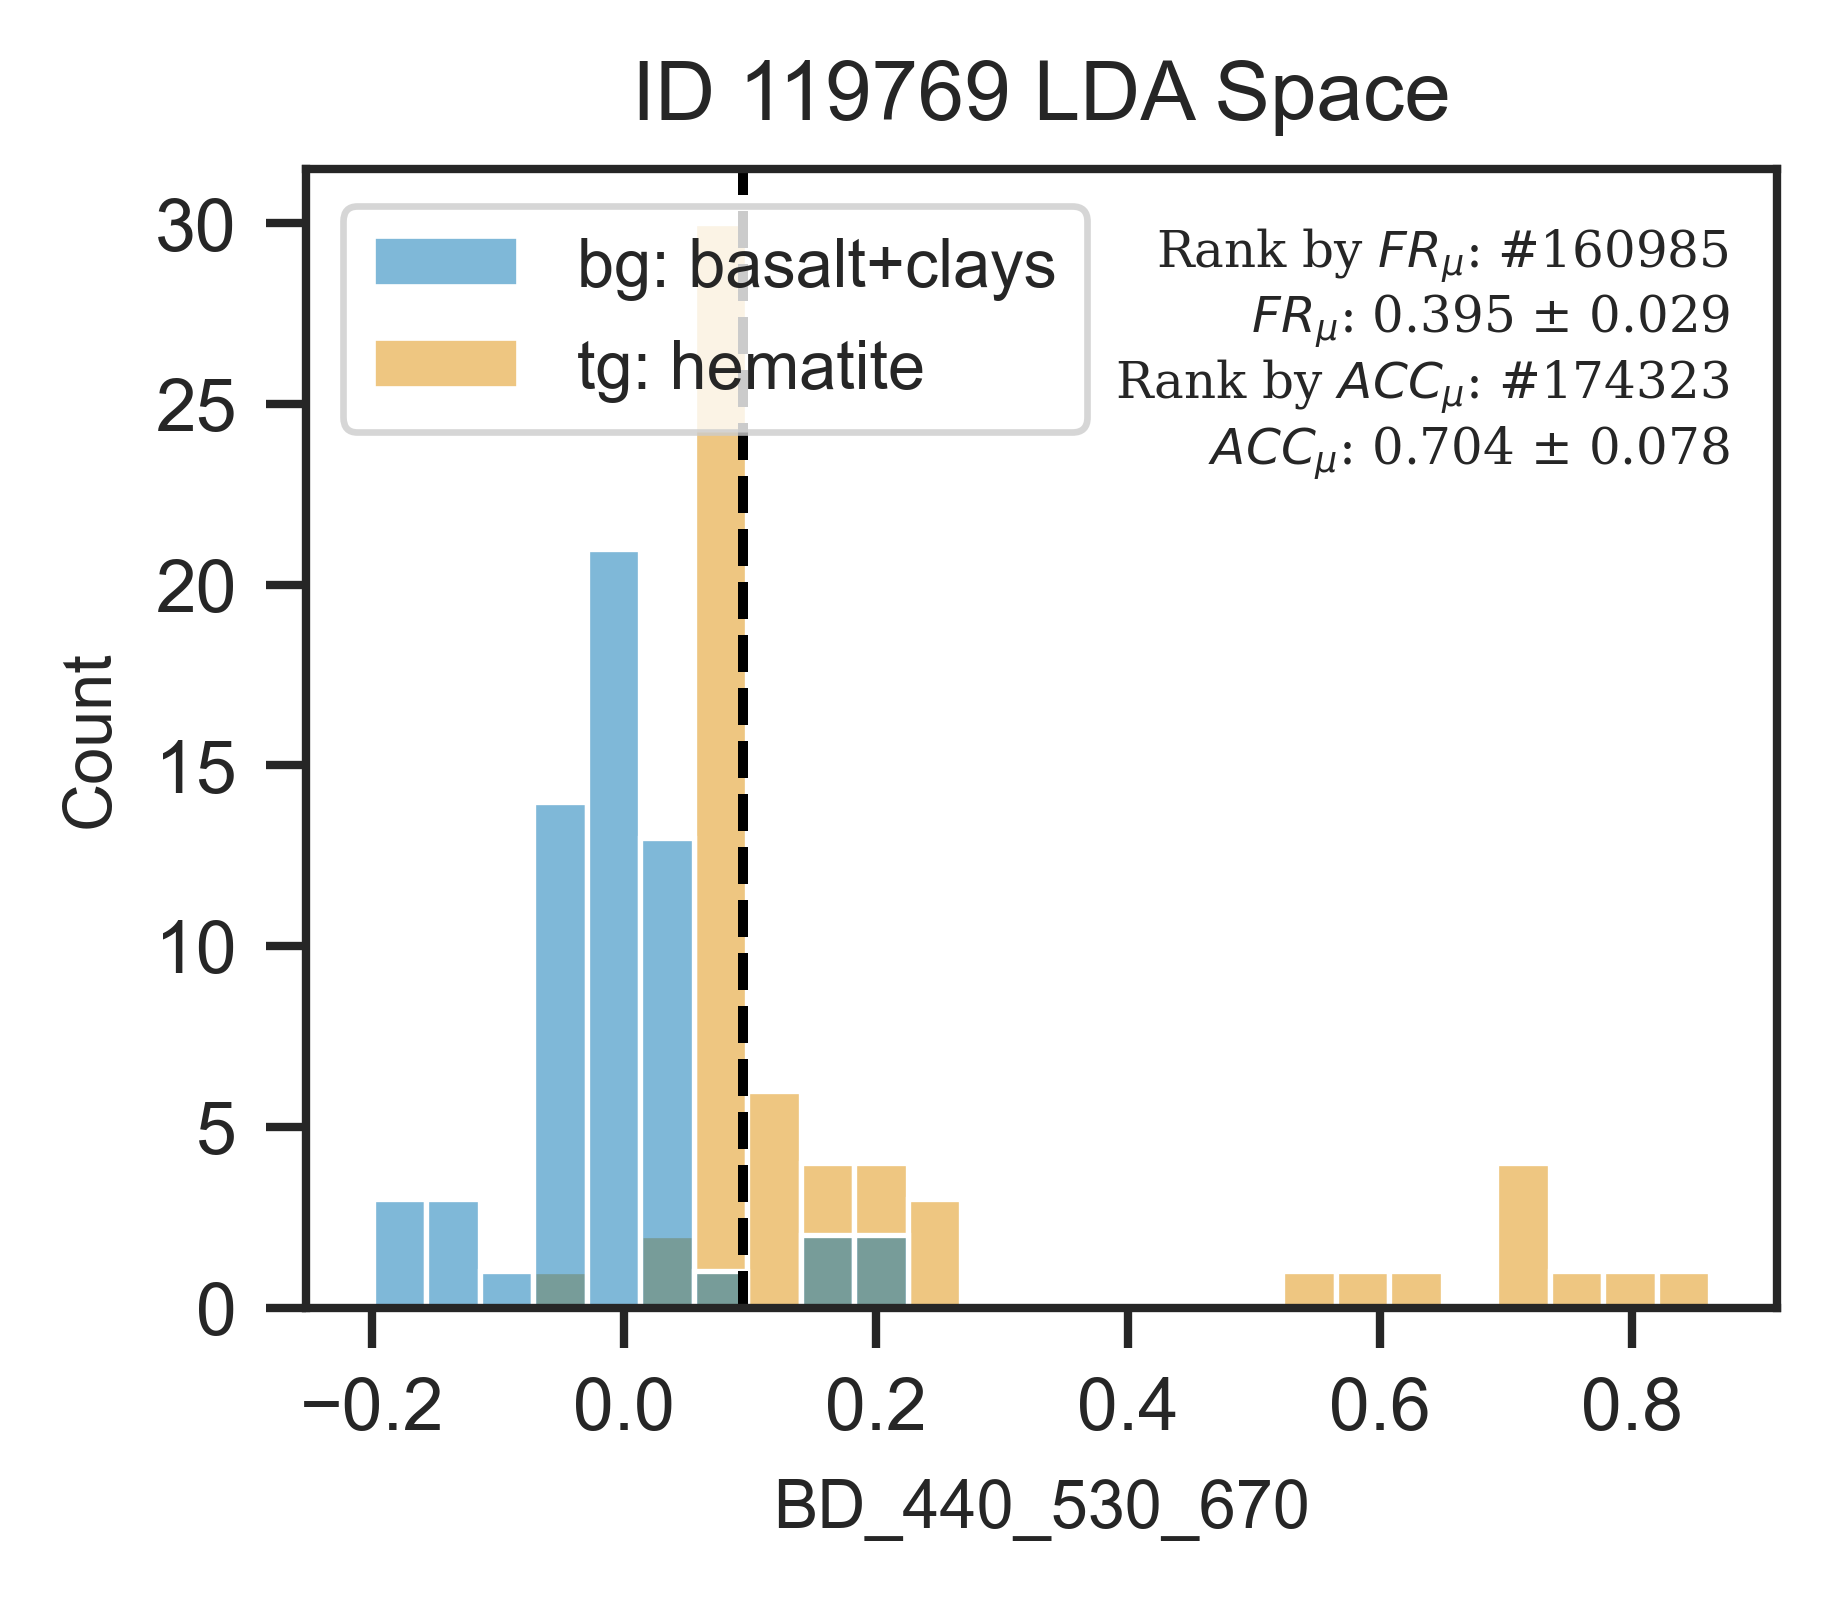

In [ ]:
this_spc_id = spc.main_df.loc[(spc.main_df['sp_0'] == 'BD_440_530_670') & (spc.main_df['sp_1'] == 'BD_440_530_670')].index.item()
spc.plot_spc_lda(spc_id=this_spc_id, spectral_parameters=sps)

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_None-None_NA_BD_440_530_670_LDA.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_None-None_NA_BD_440_530_670_LDA.png)

## Dataset 22

Data for Figure 6. C

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_None-None_NA_BD_440_530_670_LDA_data.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_None-None_NA_BD_440_530_670_LDA_data.csv)

## Figure 6. D

<Figure size 314.961x275.591 with 0 Axes>

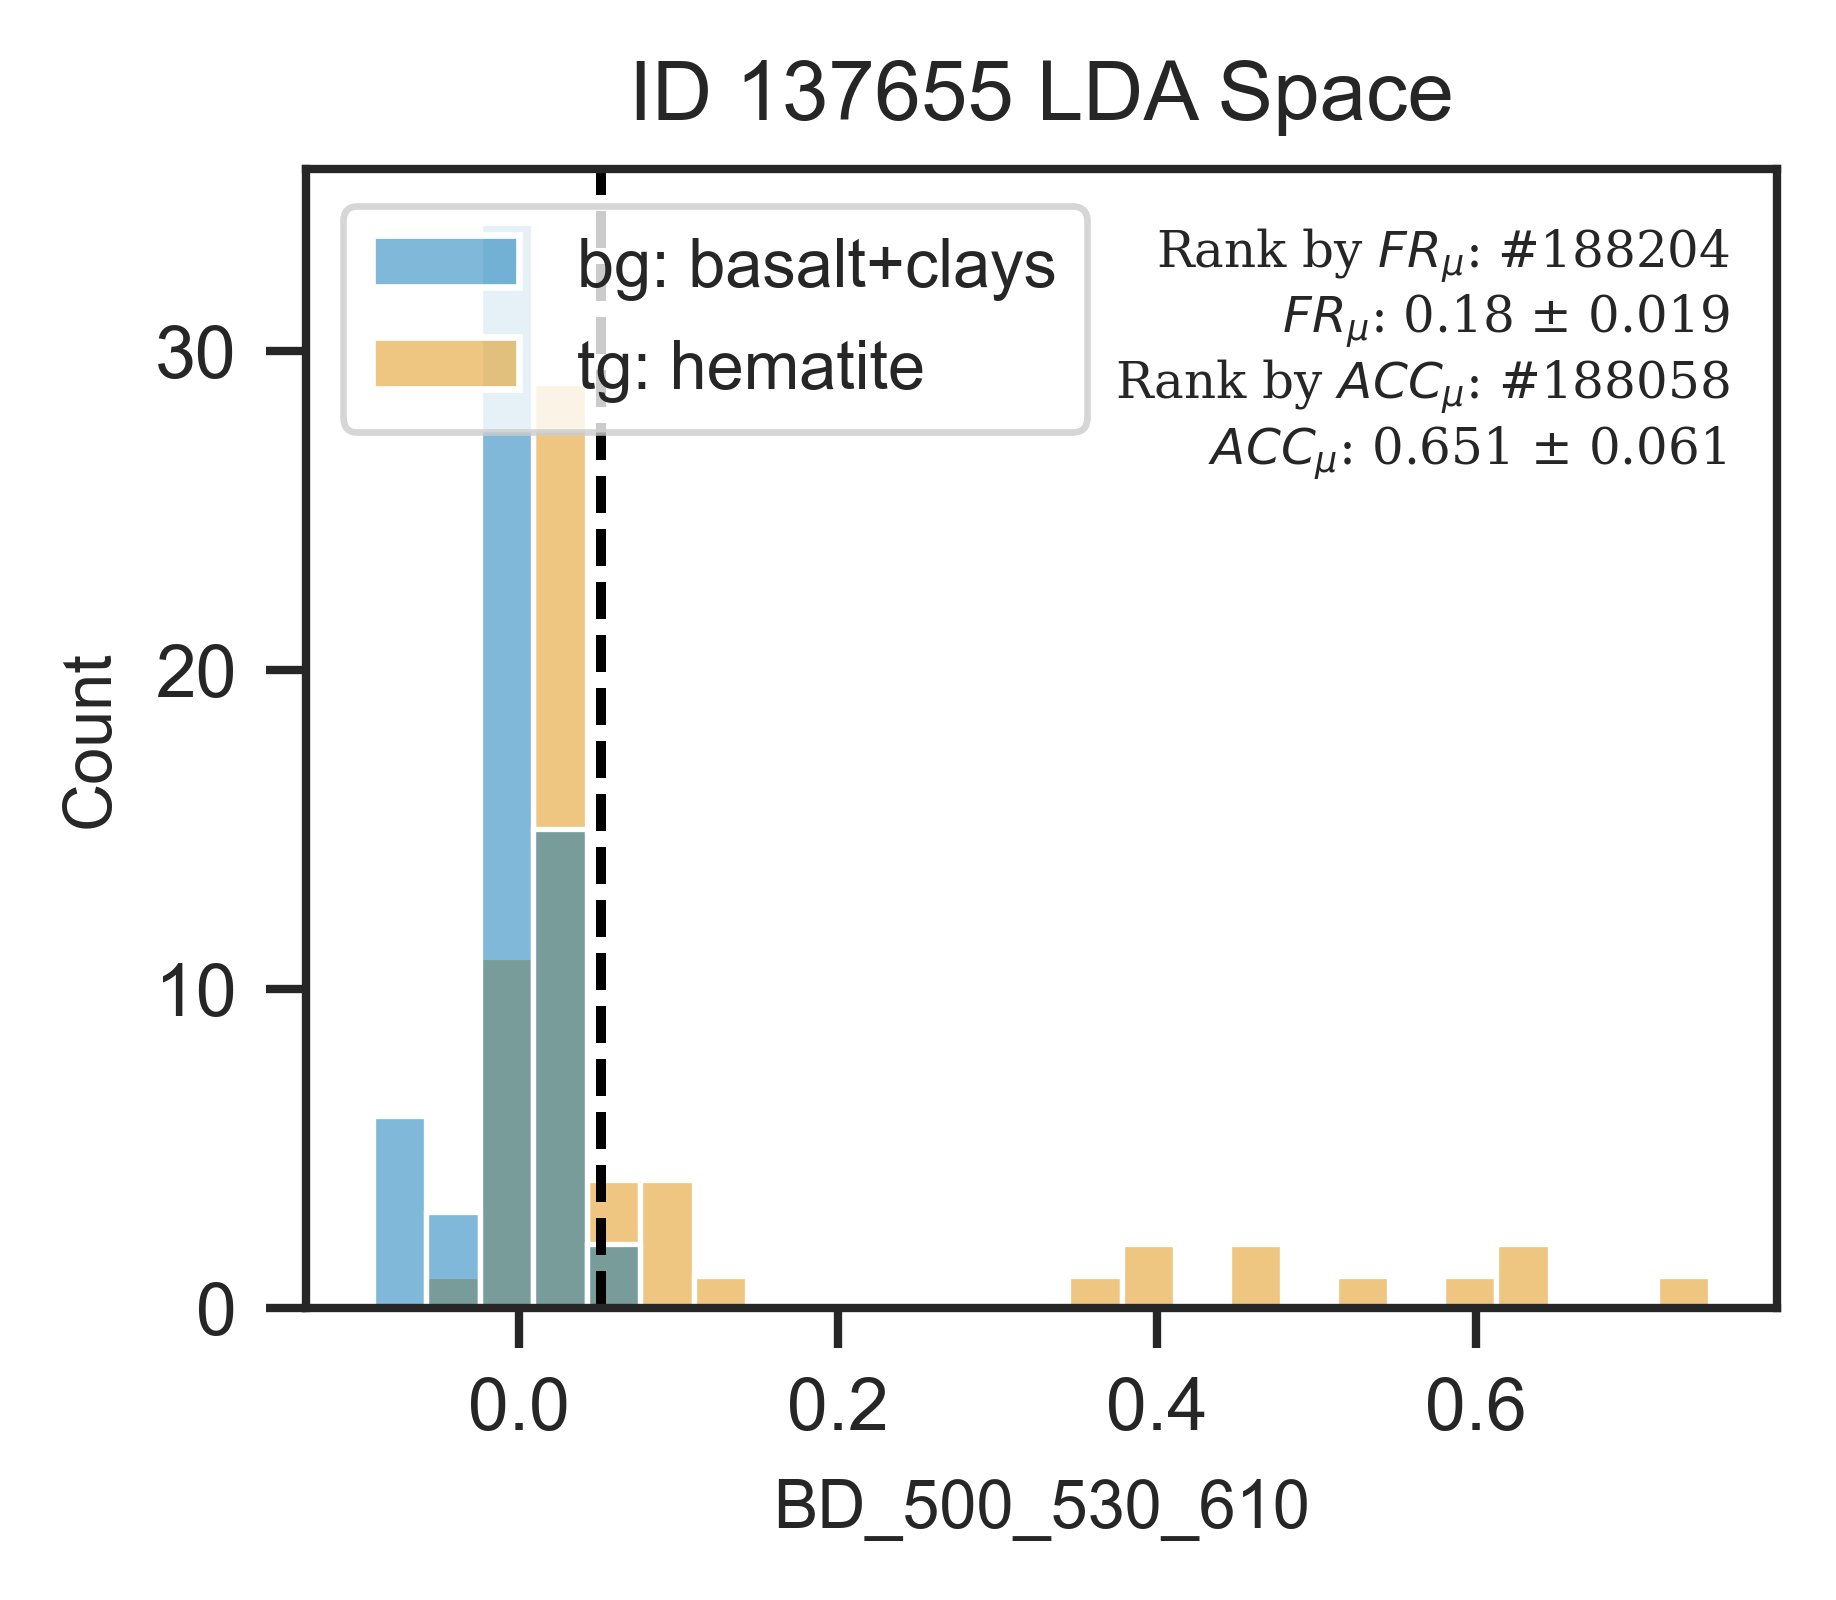

In [ ]:
this_spc_id = spc.main_df.loc[(spc.main_df['sp_0'] == 'BD_500_530_610') & (spc.main_df['sp_1'] == 'BD_500_530_610')].index.item()
spc.plot_spc_lda(spc_id=this_spc_id, spectral_parameters=sps)

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_None-None_NA_BD_500_530_610_LDA.png](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_None-None_NA_BD_500_530_610_LDA.png)

## Dataset 23

Data for Figure 6. D

Original File link:
[../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_None-None_NA_BD_500_530_610_LDA_data.csv](../projects/stabbins2024_exmpc_hematite_paper_data_products/spc_classifier/lda_plots/nuc_3_rank_None-None_NA_BD_500_530_610_LDA_data.csv)

# Conclusions

This completes the reproduction of all figures and data used in the paper.